In [11]:
from fitter import Fitter, get_common_distributions, get_distributions
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import psycopg
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.stats import epps_singleton_2samp as epps
import statsmodels
import statsmodels.api as sm
import seaborn as sns
import sqlalchemy
import psycopg_binary

Formatter for the visualizations

In [12]:
def append_percentage(x, pos):
    del pos
    return str(int(x))+str('%')

def formatter(x, pos):
    del pos
    return str(int(x*100))+str('%')

In [13]:
# sns.set(
#     context="paper",
#     style="darkgrid",
#     palette="pastel",
#     rc={"figure.dpi": 150}
# )
sns.set_context("paper", font_scale=1.5)

In [14]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "expon", "exponnorm", "lognorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [5]:
def use_fitter(data):
    # Initialize the fitter object
    # f = Fitter(data, distributions='common')
    f = Fitter(data)

    # Fit common distributions
    f.fit(get_common_distributions())

    # Print the summary of the fitted distributions
    print(f.summary())

    print (f.get_best(method = 'sumsquare_error'))
    print (f.get_best(method = 'aic'))
    print (f.get_best(method = 'bic'))
    # print (f.get_best(method = 'kl_div'))
    print (f.get_best(method = 'ks_statistic'))
    print (f.get_best(method = 'ks_pvalue'))

In [ ]:
# https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3
# Link to the statistical code

# TimeOutOfDateCombined

In [3]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "time-out-of-date-from-db"), "time_out_of_date_combined.csv")
print (data_file)
df_combined = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'total_duration', 'out_of_date_duration', 'ratio', 'avg_total_duration', 'avg_out_of_date_duration', 'avg_ratio'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'out_of_date_duration', 'ratio', 'dependents_approx']
rows = df_combined.shape[0]
print (df_combined.shape)
display(df_combined.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/time-out-of-date-from-db/time_out_of_date_combined.csv
(1606643, 7)


,system_name,total_duration,out_of_date_duration,ratio,avg_total_duration,avg_out_of_date_duration,avg_ratio
0,CARGO,310,0,0.000000,310.0,0.0,0.000000
1,CARGO,1650,1491,0.903636,1650.0,1491.0,0.903636
2,CARGO,3207,1111,0.346430,1603.5,555.5,0.346430
3,CARGO,198,15,0.075758,198.0,15.0,0.075758
4,CARGO,2407,0,0.000000,2407.0,0.0,0.000000


In [4]:
df_combined = df_combined.dropna()

/var/folders/gq/329v3h5j3lv50j_25gdv3d8m0000gq/T/ipykernel_3546/1876456980.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_combined, y='avg_out_of_date_duration', x='system_name', inner='quartile',


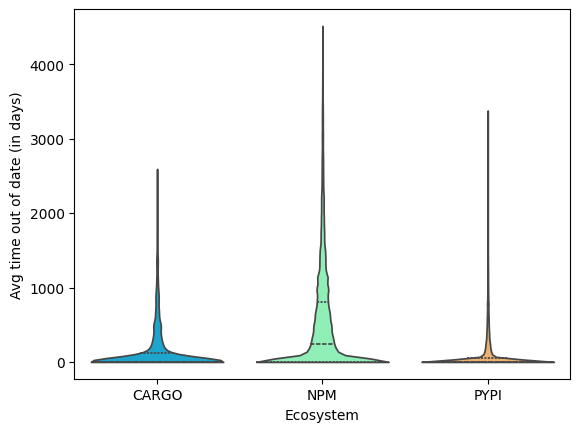

In [5]:
ax = sns.violinplot(data=df_combined, y='avg_out_of_date_duration', x='system_name', inner='quartile',
                    palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "time_out_of_date_combined.pdf")

ax.set_ylabel('Avg time out of date (in days)')
ax.set_xlabel('Ecosystem')
# plt.title('Time out of date (all pkgs)\n')
plt.savefig(data_file)


/var/folders/gq/329v3h5j3lv50j_25gdv3d8m0000gq/T/ipykernel_3546/2631486434.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_combined, y='avg_ratio', x='system_name', inner='quartile',


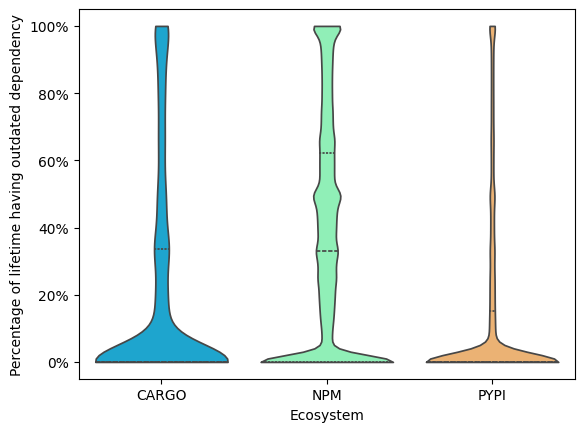

In [6]:
ax = sns.violinplot(data=df_combined, y='avg_ratio', x='system_name', inner='quartile',
                    palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "time_out_of_date_combined_ratio.pdf")

ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Ecosystem')
ax.set_ylabel('Percentage of lifetime having outdated dependency')
# plt.title('Time out of date (all pkgs)\n')
plt.savefig(data_file)

In [7]:
for system_name in df_combined.system_name.unique():
    print (system_name)

CARGO
NPM
PYPI


Cumulative Percentage Graph

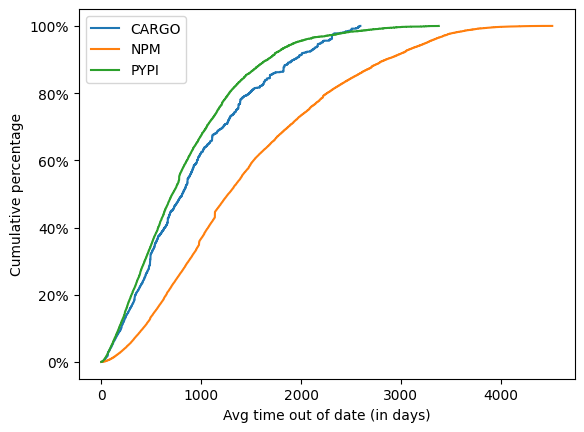

In [8]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 4.8))

data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "cum_percentage_tood.pdf")

for system_name in df_combined.system_name.unique():
    df_cpg = df_combined[df_combined['system_name']==system_name].sort_values(by='avg_out_of_date_duration')
    df_cpg['cumulative_sum'] = df_cpg['avg_out_of_date_duration'].cumsum()
    df_cpg['cumulative_percentage'] = 100 * df_cpg['cumulative_sum'] / df_cpg['avg_out_of_date_duration'].sum()
    plt.plot(df_cpg['avg_out_of_date_duration'], df_cpg['cumulative_percentage'], drawstyle='steps', label=system_name)

ax.yaxis.set_major_formatter(append_percentage)
plt.xlabel('Avg time out of date (in days)')
plt.ylabel('Cumulative percentage')
# plt.title('Cumulative Percentage Graph')
plt.legend()
plt.savefig(data_file)

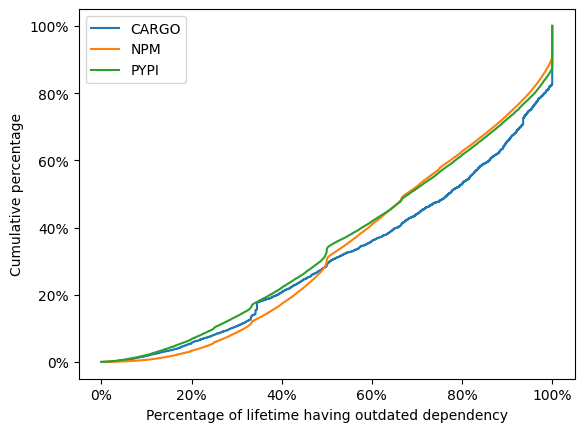

In [9]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 4.8))

data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "cum_percentage_ratio.pdf")
for system_name in df_combined.system_name.unique():
    df_cpg = df_combined[df_combined['system_name']==system_name].sort_values(by='avg_ratio')
    df_cpg['cumulative_sum'] = df_cpg['avg_ratio'].cumsum()
    df_cpg['cumulative_percentage'] = 100 * df_cpg['cumulative_sum'] / df_cpg['avg_ratio'].sum()
    plt.plot(df_cpg['avg_ratio'], df_cpg['cumulative_percentage'], drawstyle='steps', label=system_name)


ax.yaxis.set_major_formatter(append_percentage)
ax.xaxis.set_major_formatter(formatter)
plt.xlabel('Percentage of lifetime having outdated dependency')
plt.ylabel('Cumulative percentage')
# plt.title('Cumulative Percentage Graph')
plt.legend()
plt.savefig(data_file)

# TimeOutOfDateMaintained

In [15]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "time-out-of-date-from-db"), "time_out_of_date_combined_maintained.csv")
print (data_file)
df_combined_maintained = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'total_duration', 'out_of_date_duration', 'ratio', 'avg_total_duration', 'avg_out_of_date_duration', 'avg_ratio'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'out_of_date_duration', 'ratio', 'dependents_approx']
rows = df_combined_maintained.shape[0]
print (df_combined_maintained.shape)
display(df_combined_maintained.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/time-out-of-date-from-db/time_out_of_date_combined_maintained.csv
(1505261, 7)


,system_name,total_duration,out_of_date_duration,ratio,avg_total_duration,avg_out_of_date_duration,avg_ratio
0,CARGO,310,0,0.000000,310.0,0.0,0.000000
1,CARGO,1650,1491,0.903636,1650.0,1491.0,0.903636
2,CARGO,3207,1111,0.346430,1603.5,555.5,0.346430
3,CARGO,198,15,0.075758,198.0,15.0,0.075758
4,CARGO,2407,0,0.000000,2407.0,0.0,0.000000


In [16]:
df_combined_maintained = df_combined_maintained.dropna()

In [17]:
df_combined_maintained

,system_name,total_duration,out_of_date_duration,ratio,avg_total_duration,avg_out_of_date_duration,avg_ratio
0,CARGO,310,0,0.000000,310.000000,0.0,0.000000
1,CARGO,1650,1491,0.903636,1650.000000,1491.0,0.903636
2,CARGO,3207,1111,0.346430,1603.500000,555.5,0.346430
3,CARGO,198,15,0.075758,198.000000,15.0,0.075758
4,CARGO,2407,0,0.000000,2407.000000,0.0,0.000000
...,...,...,...,...,...,...,...
1505256,PYPI,447,447,1.000000,447.000000,447.0,1.000000
1505257,PYPI,347,0,0.000000,57.833333,0.0,0.000000
1505258,PYPI,1330,0,0.000000,1330.000000,0.0,0.000000
1505259,PYPI,1592,0,0.000000,796.000000,0.0,0.000000


In [18]:
df_combined_maintained.groupby('system_name')['avg_out_of_date_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
system_name,,,,,,,,
CARGO,9690.0,165.547943,357.377732,0.0,0.0,0.000000,137.000000,2594.000000
NPM,1366592.0,581.542476,743.370011,0.0,0.0,287.519481,910.918269,4495.333333
PYPI,128979.0,108.549911,284.497012,0.0,0.0,0.000000,42.818182,3438.500000


In [17]:
get_best_distribution(df_combined_maintained.loc[df_combined_maintained['system_name']=='CARGO', 'avg_out_of_date_duration'].sort_values().to_numpy())

p value for norm = 0.0
p value for exponweib = 0.0
p value for weibull_max = 0.0
p value for weibull_min = 0.0
p value for pareto = 0.0
p value for genextreme = 0.0
p value for expon = 0.0
p value for exponnorm = 0.0
p value for lognorm = 0.0
Best fitting distribution: norm
Best p value: 0.0
Parameters for the best fit: (165.54794284169702, 357.35929083584665)


('norm', 0.0, (165.54794284169702, 357.35929083584665))

Fitting 111 distributions:   0%|          | 0/111 [00:00<?, ?it/s]2024-01-28 19:00:34.146 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-01-28 19:00:34.406 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=0.000545)
Fitting 111 distributions:   3%|▎         | 3/111 [00:00<00:19,  5.63it/s]2024-01-28 19:00:34.765 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cosine distribution with error=0.000541)
2024-01-28 19:00:34.768 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=0.000482)
Fitting 111 distributions:   5%|▌         | 6/111 [00:00<00:16,  6.47it/s]2024-01-28 19:00:35.116 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.000408)
2024-01-28 19:00:35.122 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.00036)
2

           sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta              0.000117  4534.853666  4563.569065     inf      0.533953   
gengamma          0.000117  2200.018577  2228.733976     inf      0.533953   
lomax             0.000123  2119.090983  2140.627532     inf      0.533953   
gibrat            0.000170  2572.496618  2586.854318     inf      0.408258   
exponweib         0.000172  2329.145034  2357.860433     inf      0.533953   

           ks_pvalue  
beta             0.0  
gengamma         0.0  
lomax            0.0  
gibrat           0.0  
exponweib        0.0  
{'beta': {'a': 0.6030440279265958, 'b': 203.7139184345178, 'loc': -5.397613624116302e-26, 'scale': 16477.8895231293}}
{'vonmises': {'kappa': 1.2242144610158532, 'loc': 0.032198829493300885, 'scale': 1}}
{'vonmises': {'kappa': 1.2242144610158532, 'loc': 0.032198829493300885, 'scale': 1}}
{'genlogistic': {'c': 2608.883171791973, 'loc': -1115.3286241615533, 'scale': 148.01974355157202}}
{'angl

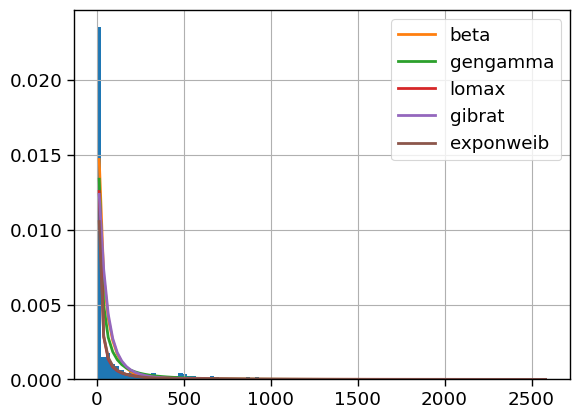

In [10]:
use_fitter(df_combined_maintained.loc[df_combined_maintained['system_name']=='CARGO', 'avg_out_of_date_duration'].sort_values().to_numpy())

Fitting 111 distributions:   2%|▏         | 2/111 [00:20<21:17, 11.72s/it]2024-01-28 19:03:36.832 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED alpha distribution (taking more than 30 seconds)
2024-01-28 19:03:36.866 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED arcsine distribution (taking more than 30 seconds)
Fitting 111 distributions:   3%|▎         | 3/111 [00:30<20:00, 11.12s/it]2024-01-28 19:03:36.867 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED anglit distribution (taking more than 30 seconds)
2024-01-28 19:03:36.888 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED argus distribution (taking more than 30 seconds)
Fitting 111 distributions:   5%|▍         | 5/111 [00:30<08:36,  4.87s/it]2024-01-28 19:03:36.888 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED betaprime distribution (taking more than 30 seconds)
2024-01-28 19:03:36.900 | WARNING  | fitter.fitter:_fit_single_distribution:

          sumsquare_error          aic          bic    kl_div  ks_statistic  \
pareto           0.000033  2052.138517  2088.522009  0.239631      0.261525   
expon            0.000033  2050.138522  2074.394183  0.239631      0.261525   
cauchy           0.000041  2079.361534  2103.617195  0.390273      0.314762   
gumbel_r         0.000043  2141.982269  2166.237930  0.337526      0.155233   
laplace          0.000044  2149.178580  2173.434241  0.351513      0.289104   

          ks_pvalue  
pareto          0.0  
expon           0.0  
cauchy          0.0  
gumbel_r        0.0  
laplace         0.0  
{'pareto': {'b': 59083799.68684511, 'loc': -34359738368.0, 'scale': 34359738367.999996}}
{'vonmises': {'kappa': 0.5641443446101998, 'loc': 0.009340144928520644, 'scale': 1}}
{'vonmises': {'kappa': 0.5641443446101998, 'loc': 0.009340144928520644, 'scale': 1}}
{'gumbel_r': {'loc': 278.36980747111824, 'scale': 447.46981204392404}}
{'cauchy': {'loc': 170.4302547009992, 'scale': 259.032867724301

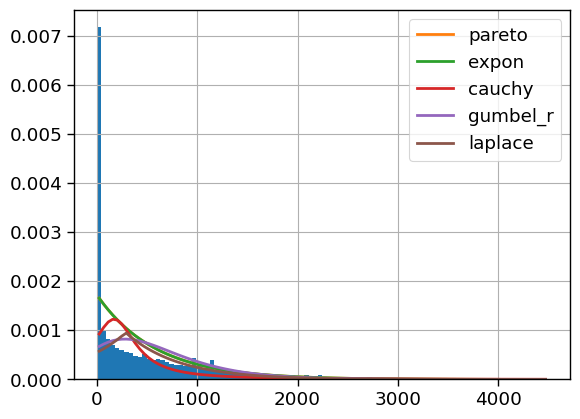

In [11]:
use_fitter(df_combined_maintained.loc[df_combined_maintained['system_name']=='NPM', 'avg_out_of_date_duration'].sort_values().to_numpy())

Fitting 111 distributions:   2%|▏         | 2/111 [00:32<33:39, 18.52s/it]2024-01-28 19:10:56.280 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED anglit distribution (taking more than 30 seconds)
2024-01-28 19:10:56.301 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED arcsine distribution (taking more than 30 seconds)
2024-01-28 19:10:56.401 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED argus distribution (taking more than 30 seconds)
Fitting 111 distributions:   5%|▌         | 6/111 [00:32<06:31,  3.73s/it]2024-01-28 19:10:56.467 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED betaprime distribution (taking more than 30 seconds)
2024-01-28 19:10:56.467 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED bradford distribution (taking more than 30 seconds)
Fitting 111 distributions:  13%|█▎        | 14/111 [00:35<00:54,  1.78it/s]2024-01-28 19:11:26.553 | WARNING  | fitter.fitter:_fit_single_distribut

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon            0.000230  4109.109290  4128.644100     inf      0.661683   
pareto           0.000230  4111.109179  4140.411394     inf      0.661683   
laplace          0.000314  4247.738726  4267.273536     inf      0.500000   
gumbel_r         0.000340  4279.673066  4299.207876     inf      0.394851   
logistic         0.000372  4372.067685  4391.602495     inf      0.383153   

          ks_pvalue  
expon           0.0  
pareto          0.0  
laplace         0.0  
gumbel_r        0.0  
logistic        0.0  
{'expon': {'loc': 0.0, 'scale': 108.54991074935204}}
{'vonmises': {'kappa': 1.8139532173621369, 'loc': 0.01952414825583615, 'scale': 1}}
{'vonmises': {'kappa': 1.8139532173621369, 'loc': 0.01952414825583615, 'scale': 1}}
{'norm': {'loc': 108.54991074935204, 'scale': 284.4959092915413}}
{'expon': {'loc': 0.0, 'scale': 108.54991074935204}}


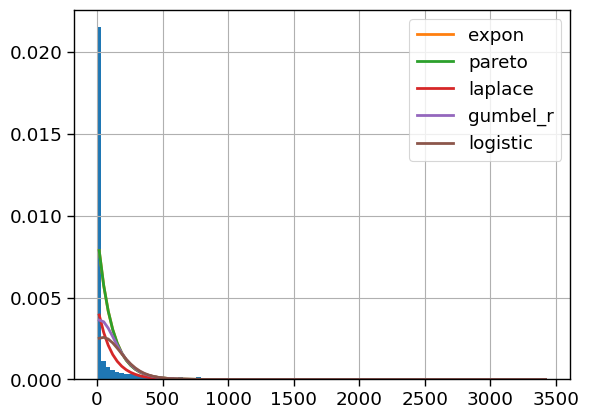

In [12]:
use_fitter(df_combined_maintained.loc[df_combined_maintained['system_name']=='PYPI', 'avg_out_of_date_duration'].sort_values().to_numpy())

Fitting 111 distributions:   2%|▏         | 2/111 [00:32<33:47, 18.60s/it]2024-01-28 19:19:35.253 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED anglit distribution (taking more than 30 seconds)
2024-01-28 19:19:35.311 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED arcsine distribution (taking more than 30 seconds)
Fitting 111 distributions:   5%|▍         | 5/111 [00:33<07:33,  4.28s/it]2024-01-28 19:19:35.455 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED beta distribution (taking more than 30 seconds)
2024-01-28 19:19:35.510 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED betaprime distribution (taking more than 30 seconds)
Fitting 111 distributions:  13%|█▎        | 14/111 [00:38<01:29,  1.09it/s]2024-01-28 19:20:05.575 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED cosine distribution (taking more than 30 seconds)
2024-01-28 19:20:05.647 | WARNING  | fitter.fitter:_fit_single_distribution

          sumsquare_error          aic          bic    kl_div  ks_statistic  \
expon            0.000043  2096.738940  2121.187894  0.289576      0.298174   
gumbel_r         0.000055  2190.587030  2215.035983  0.391174      0.170288   
laplace          0.000055  2198.022341  2222.471294  0.392139      0.319071   
rayleigh         0.000057  2303.551407  2328.000361  0.424801      0.214345   
logistic         0.000058  2253.407783  2277.856737  0.433368      0.245758   

          ks_pvalue  
expon           0.0  
gumbel_r        0.0  
laplace         0.0  
rayleigh        0.0  
logistic        0.0  
{'expon': {'loc': 0.0, 'scale': 538.3359518576809}}
{'vonmises': {'kappa': 0.6447690425642607, 'loc': 0.011480867800855332, 'scale': 1}}
{'vonmises': {'kappa': 0.6447690425642607, 'loc': 0.011480867800855332, 'scale': 1}}
{'gumbel_r': {'loc': 246.4694184511407, 'scale': 424.604929060735}}
{'expon': {'loc': 0.0, 'scale': 538.3359518576809}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


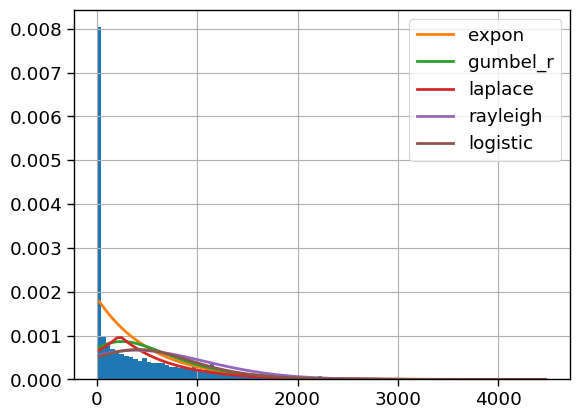

In [13]:
use_fitter(df_combined_maintained['avg_out_of_date_duration'].sort_values().to_numpy())

/var/folders/gq/329v3h5j3lv50j_25gdv3d8m0000gq/T/ipykernel_51838/3596571368.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_combined_maintained, x='avg_out_of_date_duration', y='system_name', inner='quartile',


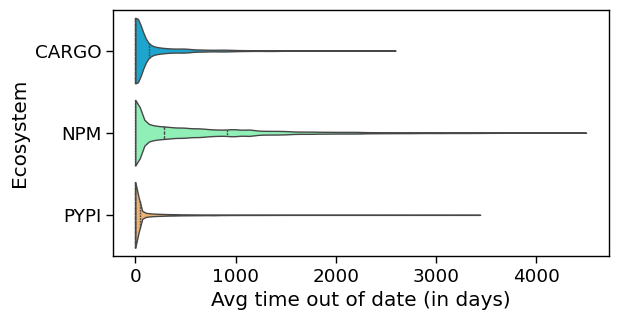

In [54]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.violinplot(data=df_combined_maintained, x='avg_out_of_date_duration', y='system_name', inner='quartile',
                    palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "time_out_of_date_combined_maintained.pdf")

ax.set_xlabel('Avg time out of date (in days)')
ax.set_ylabel('Ecosystem')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

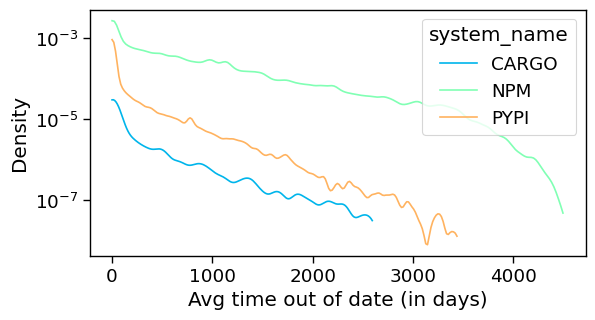

In [53]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.kdeplot(data=df_combined_maintained, x='avg_out_of_date_duration', hue='system_name',
                palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "time_out_of_date_combined_maintained_kde.pdf")

ax.set_ylabel('Density')
ax.set_xlabel('Avg time out of date (in days)')
ax.set_yscale('log')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

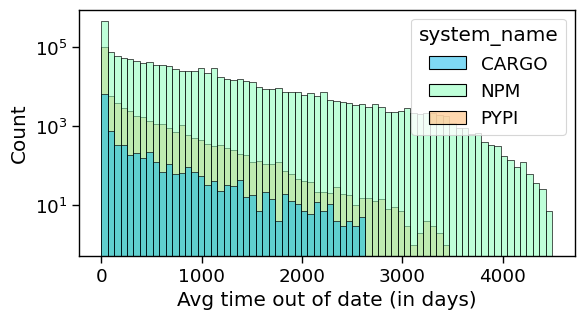

In [55]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.histplot(data=df_combined_maintained, x='avg_out_of_date_duration', hue='system_name',
                palette='rainbow', bins=70)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "time_out_of_date_combined_maintained_hist.pdf")

# ax.set_ylabel('Density')
ax.set_xlabel('Avg time out of date (in days)')
ax.set_yscale('log')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

Fitting 111 distributions:   1%|          | 1/111 [00:03<06:33,  3.57s/it]2024-01-28 19:30:32.408 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED arcsine distribution (taking more than 30 seconds)
2024-01-28 19:30:32.463 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED anglit distribution (taking more than 30 seconds)
Fitting 111 distributions:   4%|▎         | 4/111 [00:34<11:54,  6.68s/it]2024-01-28 19:30:32.704 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED bradford distribution (taking more than 30 seconds)
2024-01-28 19:30:32.777 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED argus distribution (taking more than 30 seconds)
Fitting 111 distributions:  14%|█▍        | 16/111 [01:05<08:35,  5.43s/it]2024-01-28 19:31:04.142 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED dgamma distribution (taking more than 30 seconds)
2024-01-28 19:31:04.487 | WARNING  | fitter.fitter:_fit_single_distribution

          sumsquare_error         aic         bic    kl_div  ks_statistic  \
pareto        2709.748759  169.978462  191.515011  1.030444      0.533952   
expon         2709.748762  167.978448  182.336147  1.030444      0.533953   
laplace       2843.573857  306.607884  320.965583  1.030444      0.500000   
gumbel_r      2923.621052  177.770102  192.127802  1.048727      0.319193   
rayleigh      2965.232090  120.096874  134.454573  1.003751      0.353120   

          ks_pvalue  
pareto          0.0  
expon           0.0  
laplace         0.0  
gumbel_r        0.0  
rayleigh        0.0  
{'pareto': {'b': 319470578.17737573, 'loc': -67108864.0, 'scale': 67108863.99999999}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'vonmises': {'kappa': 10.342188992239436, 'loc': 0.20245686815421093, 'scale': 1}}
{'expon': {'loc': 0.0, 'scale': 0.21006273796900626}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


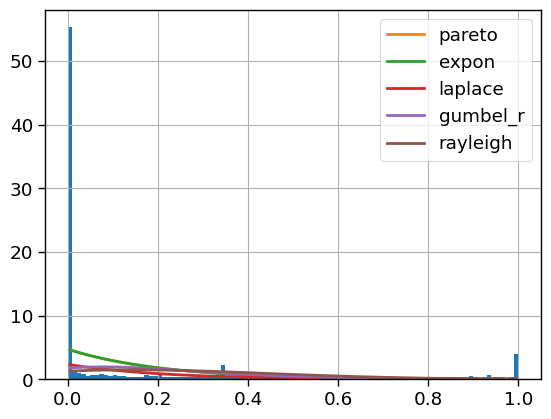

In [14]:
use_fitter(df_combined_maintained.loc[df_combined_maintained['system_name']=='CARGO', 'avg_ratio'].sort_values().to_numpy())

Fitting 111 distributions:   6%|▋         | 7/111 [00:37<04:26,  2.56s/it]2024-01-28 19:40:09.325 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED bradford distribution (taking more than 30 seconds)
2024-01-28 19:40:09.335 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED betaprime distribution (taking more than 30 seconds)
Fitting 111 distributions:   8%|▊         | 9/111 [00:38<02:26,  1.44s/it]2024-01-28 19:40:09.499 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED burr12 distribution (taking more than 30 seconds)
2024-01-28 19:40:09.538 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED chi distribution (taking more than 30 seconds)
Fitting 111 distributions:  14%|█▎        | 15/111 [01:04<11:07,  6.95s/it]2024-01-28 19:40:40.221 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED crystalball distribution (taking more than 30 seconds)
2024-01-28 19:40:41.189 | WARNING  | fitter.fitter:_fit_single_distrib

          sumsquare_error         aic         bic    kl_div  ks_statistic  \
pareto         367.796368  246.153464  282.536956  1.075330      0.278667   
expon          640.787439   71.138109   95.393771  0.571080      0.253096   
uniform        667.865965    4.000000   28.255661  0.338298      0.254262   
rayleigh       685.473726   49.747427   74.003088  0.403298      0.175448   
gumbel_r       686.254295   64.931480   89.187141  0.436596      0.156048   

          ks_pvalue  
pareto          0.0  
expon           0.0  
uniform         0.0  
rayleigh        0.0  
gumbel_r        0.0  
{'pareto': {'b': 0.4525643326601308, 'loc': -0.023483097806623127, 'scale': 0.023483097806623124}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'vonmises': {'kappa': 9.124669827832246, 'loc': 0.39481308282034355, 'scale': 1}}
{'expon': {'loc': 0.0, 'scale': 0.39690259464285194}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


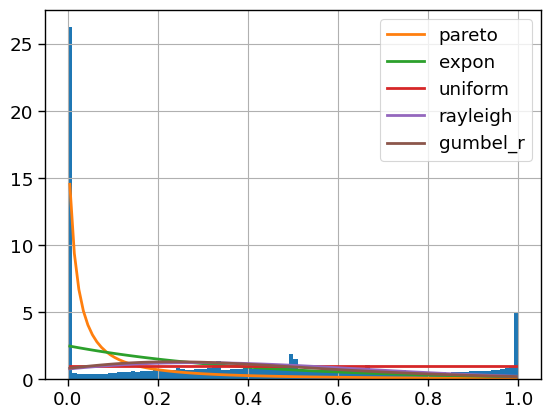

In [15]:
use_fitter(df_combined_maintained.loc[df_combined_maintained['system_name']=='NPM', 'avg_ratio'].sort_values().to_numpy())

Fitting 111 distributions:   2%|▏         | 2/111 [00:34<35:38, 19.62s/it]2024-01-28 19:52:05.634 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED anglit distribution (taking more than 30 seconds)
2024-01-28 19:52:05.899 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED arcsine distribution (taking more than 30 seconds)
Fitting 111 distributions:   5%|▌         | 6/111 [00:39<06:50,  3.91s/it]2024-01-28 19:52:06.214 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED bradford distribution (taking more than 30 seconds)
2024-01-28 19:52:06.394 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED betaprime distribution (taking more than 30 seconds)
Fitting 111 distributions:   7%|▋         | 8/111 [00:42<04:05,  2.38s/it]2024-01-28 19:52:06.521 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED cauchy distribution (taking more than 30 seconds)
2024-01-28 19:52:06.529 | WARNING  | fitter.fitter:_fit_single_distribut

          sumsquare_error         aic         bic    kl_div  ks_statistic  \
expon         3992.812328  318.235979  337.770788  1.400546      0.659417   
laplace       4237.516571  456.865415  476.400224  1.400546      0.500000   
gumbel_r      4372.762398  329.293882  348.828692  1.430670      0.402730   
logistic      4450.801130  327.817494  347.352304  1.413206      0.350777   
rayleigh      4474.215294  213.488227  233.023036  1.321580      0.439473   

          ks_pvalue  
expon           0.0  
laplace         0.0  
gumbel_r        0.0  
logistic        0.0  
rayleigh        0.0  
{'expon': {'loc': 0.0, 'scale': 0.14188850718171234}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'logistic': {'loc': 0.07765603677538742, 'scale': 0.12614198800770332}}
{'expon': {'loc': 0.0, 'scale': 0.14188850718171234}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


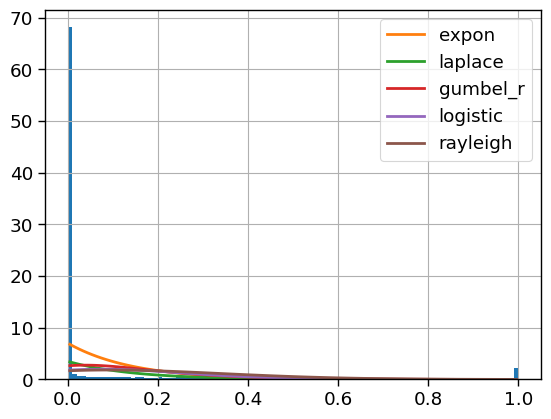

In [16]:
use_fitter(df_combined_maintained.loc[df_combined_maintained['system_name']=='PYPI', 'avg_ratio'].sort_values().to_numpy())

Fitting 111 distributions:   3%|▎         | 3/111 [00:37<21:37, 12.02s/it]2024-01-28 20:05:30.150 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED argus distribution (taking more than 30 seconds)
2024-01-28 20:05:30.252 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED anglit distribution (taking more than 30 seconds)
Fitting 111 distributions:   5%|▍         | 5/111 [00:39<08:59,  5.09s/it]2024-01-28 20:05:30.282 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED betaprime distribution (taking more than 30 seconds)
2024-01-28 20:05:30.286 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED beta distribution (taking more than 30 seconds)
Fitting 111 distributions:   9%|▉         | 10/111 [00:42<02:05,  1.24s/it]2024-01-28 20:05:30.447 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED cauchy distribution (taking more than 30 seconds)
2024-01-28 20:05:31.099 | WARNING  | fitter.fitter:_fit_single_distribution:3

          sumsquare_error         aic         bic    kl_div  ks_statistic  \
pareto         634.495817  199.890965  236.564396  1.025204      0.289720   
expon          829.406540   74.707046   99.156000  0.622428      0.289720   
uniform        872.406109    4.000000   28.448954  0.385685      0.291655   
gumbel_r       887.574354   71.220694   95.669648  0.497851      0.177878   
rayleigh       888.269260   54.222502   78.671455  0.458801      0.199872   

          ks_pvalue  
pareto          0.0  
expon           0.0  
uniform         0.0  
gumbel_r        0.0  
rayleigh        0.0  
{'pareto': {'b': 0.7027210408649738, 'loc': -0.0681240326076445, 'scale': 0.06812403260764449}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'logistic': {'loc': 0.3532583204827407, 'scale': 0.20723917702262085}}
{'expon': {'loc': 0.0, 'scale': 0.3738488250986864}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


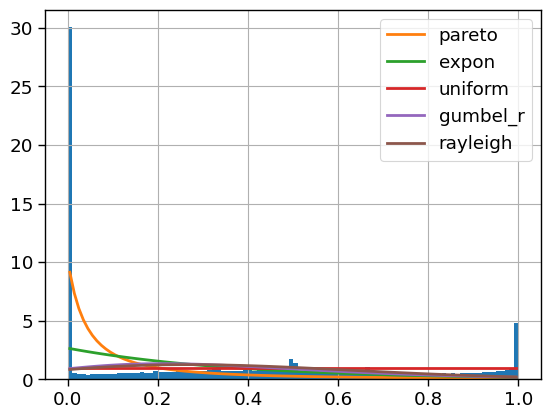

In [17]:
use_fitter(df_combined_maintained['avg_ratio'].sort_values().to_numpy())

/var/folders/gq/329v3h5j3lv50j_25gdv3d8m0000gq/T/ipykernel_51838/2969799406.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_combined_maintained, x='avg_ratio', y='system_name', inner='quartile', palette='rainbow', cut=0)


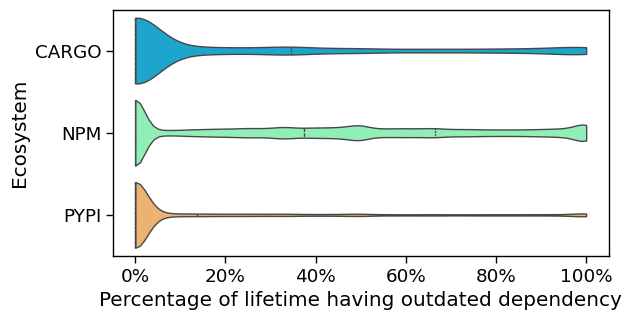

In [52]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.violinplot(data=df_combined_maintained, x='avg_ratio', y='system_name', inner='quartile', palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "time_out_of_date_combined_maintained_ratio.pdf")

ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Ecosystem')
ax.set_xlabel('Percentage of lifetime having outdated dependency')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

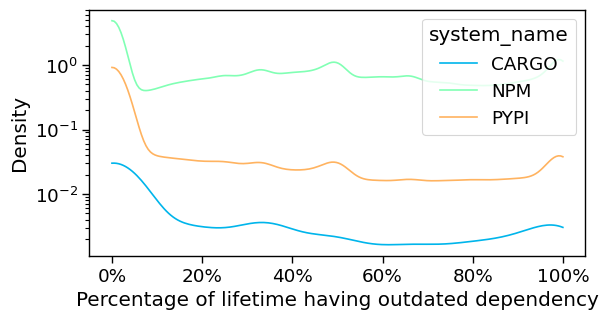

In [56]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.kdeplot(data=df_combined_maintained, x='avg_ratio', hue='system_name', palette='rainbow', cut=0)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "time_out_of_date_combined_maintained_ratio_kde.pdf")

ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Density')
ax.set_xlabel('Percentage of lifetime having outdated dependency')
ax.set_yscale('log')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

QQ plot

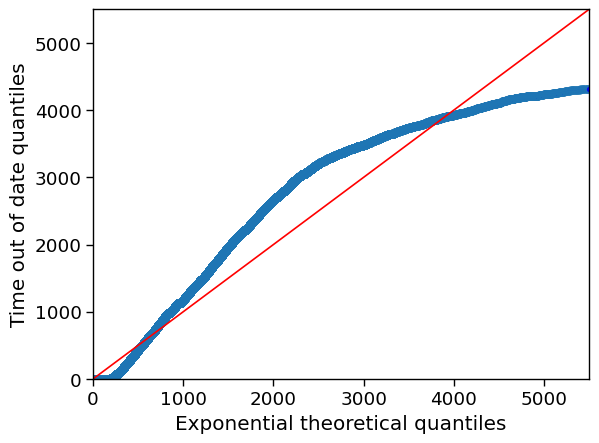

In [10]:
# fig, ax = plt.subplots(figsize=(6.4, 3.2))
loc, scale = stats.expon.fit(df_combined_maintained['avg_out_of_date_duration'].sort_values().to_numpy())
h= sm.qqplot(df_combined_maintained['avg_out_of_date_duration'].sort_values().to_numpy(),
             stats.expon, loc=loc, scale=scale, line='45', markerfacecolor='b')
h.axes[0].set_xlim([0, 5500])
h.axes[0].set_ylim([0, 5500])
h.axes[0].set_xlabel('Exponential theoretical quantiles')
h.axes[0].set_ylabel('Time out of date quantiles')
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "time_out_of_date_combined_maintained_qq_plot.png")
plt.savefig(data_file, dpi=300, bbox_inches='tight')

Cumulative Percentage Graph

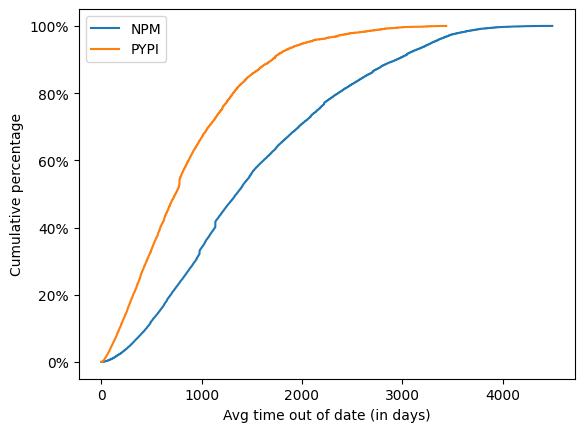

In [15]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 4.8))

data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "cum_percentage_maintained_tood.pdf")

for system_name in df_combined_maintained.system_name.unique():
    df_cpg = df_combined_maintained[df_combined_maintained['system_name']==system_name].sort_values(by='avg_out_of_date_duration')
    df_cpg['cumulative_sum'] = df_cpg['avg_out_of_date_duration'].cumsum()
    df_cpg['cumulative_percentage'] = 100 * df_cpg['cumulative_sum'] / df_cpg['avg_out_of_date_duration'].sum()
    plt.plot(df_cpg['avg_out_of_date_duration'], df_cpg['cumulative_percentage'], drawstyle='steps', label=system_name)


ax.yaxis.set_major_formatter(append_percentage)
plt.xlabel('Avg time out of date (in days)')
plt.ylabel('Cumulative percentage')
# plt.title('Cumulative Percentage Graph (Maintained)')
plt.legend()
plt.savefig(data_file)

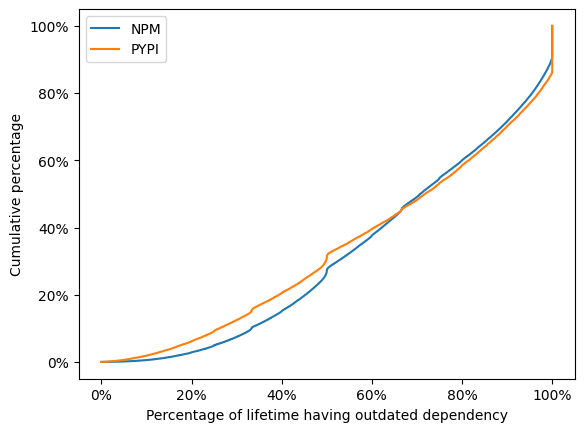

In [16]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 4.8))

data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "cum_percentage_maintained_ratio.pdf")

for system_name in df_combined_maintained.system_name.unique():
    df_cpg = df_combined_maintained[df_combined_maintained['system_name']==system_name].sort_values(by='avg_ratio')
    df_cpg['cumulative_sum'] = df_cpg['avg_ratio'].cumsum()
    df_cpg['cumulative_percentage'] = 100 * df_cpg['cumulative_sum'] / df_cpg['avg_ratio'].sum()
    plt.plot(df_cpg['avg_ratio'], df_cpg['cumulative_percentage'], drawstyle='steps', label=system_name)


ax.yaxis.set_major_formatter(append_percentage)
ax.xaxis.set_major_formatter(formatter)
plt.xlabel('Percentage of lifetime having outdated dependency')
plt.ylabel('Cumulative percentage')
# plt.title('Cumulative Percentage Graph (Maintained)')
plt.legend()
plt.savefig(data_file)

# TTU

In [84]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "ttu"), "ttu_table_without_dev.csv")
print (data_file)
df_ttu = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'from_package_name', 'year_', 'valid_ttu_in_days'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'out_of_date_duration', 'ratio', 'dependents_approx']
rows = df_ttu.shape[0]
print (df_ttu.shape)
display(df_ttu.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/ttu/ttu_table_without_dev.csv
(22009166, 4)


,system_name,from_package_name,year_,valid_ttu_in_days
0,CARGO,ArmlabRadio,2022,136
1,CARGO,HorseShoe,2019,118
2,CARGO,HorseShoe,2019,143
3,CARGO,MFEKmath,2022,16
4,CARGO,MacTypes-sys,2016,4


In [85]:
df_grouped = df_ttu.groupby(['system_name', 'from_package_name'])['valid_ttu_in_days'].mean().reset_index()
df_grouped.head()

,system_name,from_package_name,valid_ttu_in_days
0,CARGO,ArmlabRadio,136.0
1,CARGO,HorseShoe,130.5
2,CARGO,MFEKmath,16.0
3,CARGO,MacTypes-sys,8.2
4,CARGO,a11ywatch_cli,86.5


/var/folders/gq/329v3h5j3lv50j_25gdv3d8m0000gq/T/ipykernel_51838/4148842394.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_grouped, x='valid_ttu_in_days', y='system_name', inner='quartile', palette='rainbow')


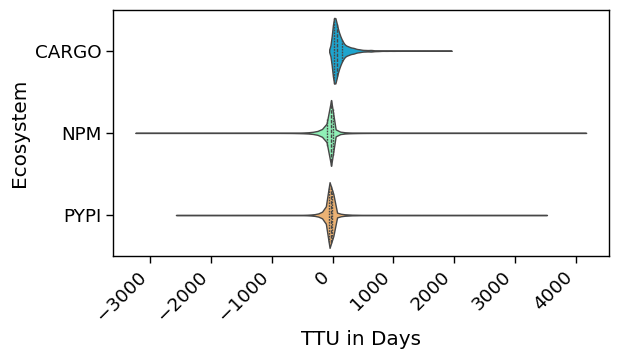

In [87]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.violinplot(data=df_grouped, x='valid_ttu_in_days', y='system_name', inner='quartile', palette='rainbow')
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "ttu"), "ttu.pdf")
ax.set_xlabel('TTU in Days')
ax.set_ylabel('Ecosystem')
plt.xticks(rotation=45, ha='right')
# plt.title('Time To Update (TTU)\n')
plt.savefig(data_file, bbox_inches='tight')

# TOOD vs # of major versions

In [19]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "time-out-of-date-from-db"), "tofd_vs_major_versions.csv")
print (data_file)
df_tood_major_versions = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'num_of_major_versions', 'avg_out_of_date_duration', 'avg_ratio', 'frequency'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'out_of_date_duration', 'ratio', 'dependents_approx']
rows = df_tood_major_versions.shape[0]
print (df_tood_major_versions.shape)
display(df_tood_major_versions.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/time-out-of-date-from-db/tofd_vs_major_versions.csv
(204, 5)


,system_name,num_of_major_versions,avg_out_of_date_duration,avg_ratio,frequency
0,CARGO,1,162.017775,0.201678,8947
1,CARGO,2,127.327316,0.211980,566
2,CARGO,3,129.875489,0.155813,163
3,CARGO,4,101.197266,0.153598,125
4,CARGO,5,57.012619,0.092798,52


In [20]:
df_tood_major_versions = df_tood_major_versions.dropna()
df_tood_major_versions.groupby(by=['system_name']).describe()

num_of_major_versions                                           \
                            count       mean         std  min    25%   50%   
system_name                                                                  
CARGO                        36.0  41.000000  118.335359  1.0   9.75  18.5   
NPM                         102.0  76.598039  158.755947  0.0  25.25  50.5   
PYPI                         65.0  64.430769  136.730685  0.0  16.00  32.0   

                           avg_out_of_date_duration              ...  \
               75%     max                    count        mean  ...   
system_name                                                      ...   
CARGO        27.25   720.0                     36.0   79.639218  ...   
NPM          80.50  1516.0                    102.0  218.972889  ...   
PYPI         60.00   878.0                     65.0   76.558203  ...   

            avg_ratio           frequency                                    \
                  75%       max     count          mean            std  min   
system_name                                                                   
CARGO        0.213725  0.605405      36.0    281.694444    1488.659777  1.0   
NPM          0.267853  1.000000     102.0  14235.656863  117844.399416  1.0   
PYPI         0.093475  0.573182      65.0   2212.753846   14267.735185  1.0   

                                        
             25%  50%   75%        max  
system_name                             
CARGO        2.0  5.5  26.0     8947.0  
NPM          1.0  4.0  41.5  1179321.0  
PYPI         1.0  2.0  11.0   114238.0  

[3 rows x 32 columns]

num_of_major_version = 0 means that it is not correctly identified the versioninfo from the database.

In [18]:
use_fitter(df_tood_major_versions.loc[df_tood_major_versions['system_name']=='CARGO', 'avg_out_of_date_duration'].to_numpy())

NameError: name 'use_fitter' is not defined

Fitting 111 distributions:   1%|          | 1/111 [00:07<13:40,  7.46s/it]2024-01-28 20:33:37.976 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=0.000165)
2024-01-28 20:33:38.463 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=0.000183)
Fitting 111 distributions:   3%|▎         | 3/111 [00:12<05:52,  3.26s/it]2024-01-28 20:33:41.463 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=0.000768)
2024-01-28 20:33:41.565 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=0.000225)
Fitting 111 distributions:   9%|▉         | 10/111 [00:30<04:55,  2.93s/it]2024-01-28 20:33:58.941 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=0.000131)
2024-01-28 20:33:59.238 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted erlang distribution with error=0.0001

                 sumsquare_error          aic          bic  kl_div  \
rel_breitwigner         0.000096  1800.674448  1808.549366     inf   
genhalflogistic         0.000102  1771.487835  1779.362754     inf   
halflogistic            0.000102  1769.397659  1774.647604     inf   
chi                     0.000106  1801.128996  1809.003915     inf   
foldnorm                0.000108  1803.530622  1811.405540     inf   

                 ks_statistic  ks_pvalue  
rel_breitwigner      0.078019   0.537888  
genhalflogistic      0.094765   0.299669  
halflogistic         0.094804   0.299214  
chi                  0.178440   0.002593  
foldnorm             0.178279   0.002625  
{'rel_breitwigner': {'rho': 0.25554339278312366, 'loc': -9.356800474241991e-10, 'scale': 545.7652444126836}}
{'vonmises': {'kappa': 0.06871064426819463, 'loc': -2.324803501452461, 'scale': 1}}
{'vonmises': {'kappa': 0.06871064426819463, 'loc': -2.324803501452461, 'scale': 1}}
{'nct': {'df': 2.852807602260144, 'nc': 1.65

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

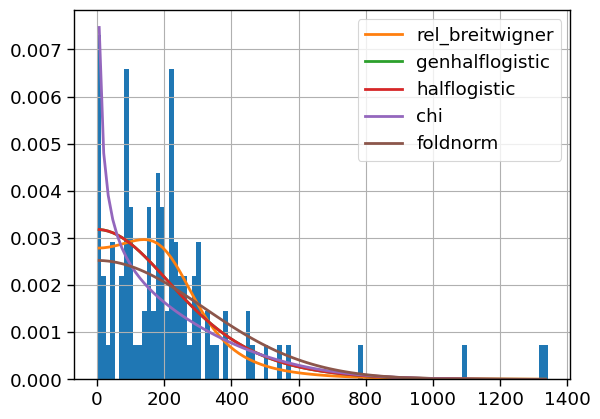

In [21]:
use_fitter(df_tood_major_versions.loc[df_tood_major_versions['system_name']=='NPM', 'avg_out_of_date_duration'].to_numpy())

Fitting 111 distributions:   3%|▎         | 3/111 [00:13<06:43,  3.74s/it]2024-01-28 20:49:38.183 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cosine distribution with error=0.001603)
2024-01-28 20:49:40.610 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=0.000244)
Fitting 111 distributions:   7%|▋         | 8/111 [00:21<03:20,  1.94s/it]2024-01-28 20:49:46.034 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.00094)
2024-01-28 20:49:46.373 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted dgamma distribution with error=0.001336)
Fitting 111 distributions:  14%|█▎        | 15/111 [00:43<03:21,  2.09s/it]2024-01-28 20:50:02.555 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted erlang distribution with error=0.000833)
2024-01-28 20:50:05.974 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED burr distribution (taking more than 30 s

           sumsquare_error          aic          bic  kl_div  ks_statistic  \
lomax             0.000207  1832.520509  1839.043671     inf      0.338462   
betaprime         0.000224  1835.654704  1844.352253     inf      0.338462   
ncf               0.000234  1875.492346  1886.364282     inf      0.338462   
alpha             0.000244  2225.656514  2232.179676     inf      0.483385   
genpareto         0.000350  1826.623989  1833.147150     inf      0.338462   

              ks_pvalue  
lomax      3.802616e-07  
betaprime  3.802614e-07  
ncf        3.802614e-07  
alpha      1.672136e-14  
genpareto  3.802615e-07  
{'lomax': {'c': 0.48278756673030204, 'loc': -1.8883843790631444e-08, 'scale': 2.2529813445865674}}
{'vonmises': {'kappa': 0.7197730695972134, 'loc': -0.025612237055478104, 'scale': 1}}
{'vonmises': {'kappa': 0.7197730695972134, 'loc': -0.025612237055478104, 'scale': 1}}
{'gumbel_r': {'loc': 30.795131143776313, 'scale': 60.48198913543775}}
{'vonmises': {'kappa': 0.719773069

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


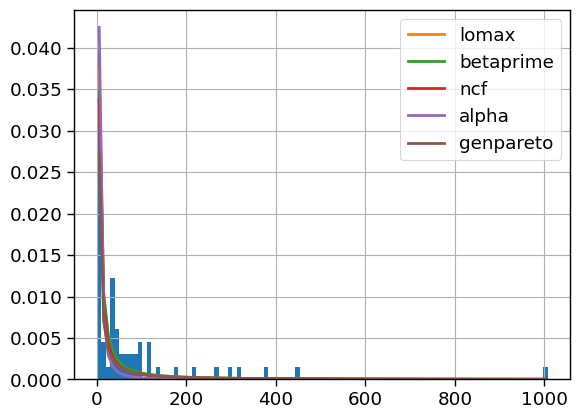

In [22]:
use_fitter(df_tood_major_versions.loc[df_tood_major_versions['system_name']=='PYPI', 'avg_out_of_date_duration'].to_numpy())

In [ ]:
use_fitter(df_tood_major_versions['avg_out_of_date_duration'].to_numpy())

In [22]:
MAX_MAJOR_VERSION = 150
df_tood_major_versions_small = df_tood_major_versions[(df_tood_major_versions['num_of_major_versions'] > 0) &
                                                        (df_tood_major_versions['num_of_major_versions'] <= MAX_MAJOR_VERSION)]

In [60]:
df_tood_major_versions_small.loc[df_tood_major_versions_small.system_name == 'NPM', 'num_of_major_versions']

37       1
38       2
39       3
40       4
41       5
      ... 
127    120
128    124
129    134
130    139
131    146
Name: num_of_major_versions, Length: 95, dtype: int64

CARGO [1.37668252e+02 3.72846709e-02 7.81091323e+00]
NPM [ 1.26528402e+05  4.89525205e-06 -1.26274002e+05]
PYPI [ 1.47511052e+05  3.42567203e-06 -1.47422240e+05]


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


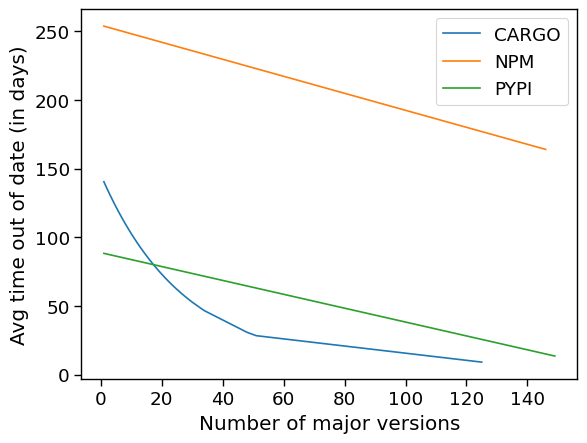

In [48]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

fig, ax = plt.subplots(figsize=(6.4, 4.8))

for system_name in df_tood_major_versions_small.system_name.unique():
    xdata=df_tood_major_versions_small.loc[df_tood_major_versions_small.system_name == system_name, 'num_of_major_versions']
    ydata=df_tood_major_versions_small.loc[df_tood_major_versions_small.system_name == system_name, 'avg_out_of_date_duration']
    popt, pcov = curve_fit(func,xdata, ydata)
    print (system_name + " "+ str(popt))
    plt.plot(xdata, func(xdata, *popt),
         # label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
             label=system_name)

ax.set_xlabel('Number of major versions')
ax.set_ylabel('Avg time out of date (in days)')
ax.legend()

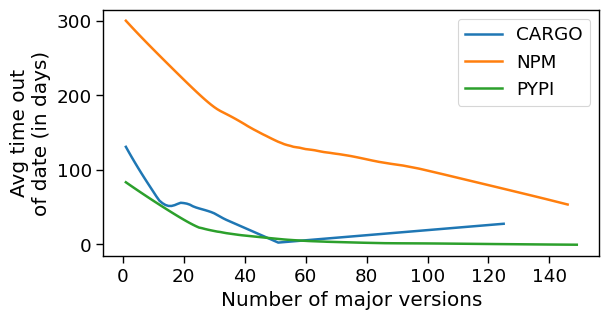

In [62]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_major_versions_small.system_name.unique():
    sns.regplot(df_tood_major_versions_small[df_tood_major_versions_small['system_name'] == system_name],
                x='num_of_major_versions',
                y='avg_out_of_date_duration',
                lowess=True,
                scatter=False,
                ax=ax,
                label=system_name)
# file to save the figure in pdf format
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_major_versions.pdf")
# plt.ylim(0.0, 1.0)


ax.set_xlabel('Number of major versions')
ax.set_ylabel('Avg time out\nof date (in days)')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

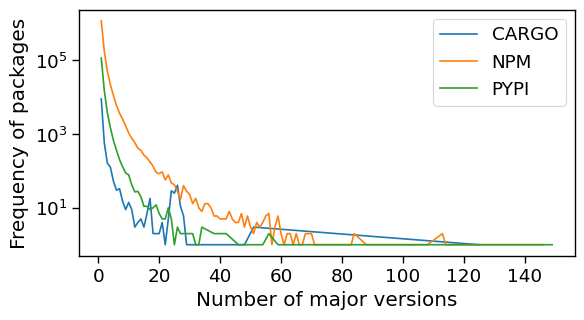

In [63]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_major_versions_small.system_name.unique():
    sns.lineplot(df_tood_major_versions_small[df_tood_major_versions_small['system_name'] == system_name],
                x='num_of_major_versions',
                y='frequency',
                ax=ax,
                label=system_name)
# file to save the figure in pdf format
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_major_versions_freq.pdf")
# plt.ylim(0.0, 1.0)

plt.yscale('log')
ax.set_xlabel('Number of major versions')
ax.set_ylabel('Frequency of packages')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

In [23]:
df_tood_major_versions_small_temp = df_tood_major_versions_small.sort_values(by=['num_of_major_versions', 'system_name'])
df_tood_major_versions_small_temp

,system_name,num_of_major_versions,avg_out_of_date_duration,avg_ratio,frequency
0,CARGO,1,162.017775,0.201678,8947
37,NPM,1,547.668270,0.381753,1179321
139,PYPI,1,99.773519,0.133131,114238
1,CARGO,2,127.327316,0.211980,566
38,NPM,2,449.649587,0.331823,171411
...,...,...,...,...,...
129,NPM,134,298.285714,0.493617,1
130,NPM,139,1.777778,0.005499,1
200,PYPI,140,3.000000,0.005046,1
131,NPM,146,0.500000,0.001185,1


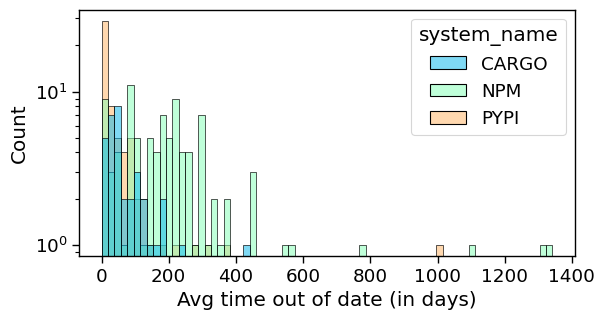

In [24]:
fig, ax = plt.subplots(figsize=(6.4, 3.2))
ax = sns.histplot(data=df_tood_major_versions_small_temp, x='avg_out_of_date_duration', hue='system_name',
                palette='rainbow', bins=70)
# plt.show()
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_major_version_hist.pdf")

# ax.set_ylabel('Density')
ax.set_xlabel('Avg time out of date (in days)')
ax.set_yscale('log')
# plt.title('Time out of date (maintained)\n')
plt.savefig(data_file, bbox_inches='tight')

Fitting 111 distributions:   3%|▎         | 3/111 [00:20<10:13,  5.68s/it]2024-01-28 21:05:49.070 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=883.456097)
2024-01-28 21:05:49.147 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=870.886059)
Fitting 111 distributions:   6%|▋         | 7/111 [00:28<04:21,  2.51s/it]2024-01-28 21:05:57.803 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=691.838386)
2024-01-28 21:05:57.966 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted dweibull distribution with error=657.444946)
Fitting 111 distributions:  10%|▉         | 11/111 [00:35<03:01,  1.82s/it]2024-01-28 21:06:03.828 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cosine distribution with error=1094.726809)
2024-01-28 21:06:05.172 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponnorm distribution 

                 sumsquare_error        aic        bic  kl_div  ks_statistic  \
chi                   602.774363  16.652872  21.403429     inf      0.106266   
mielke                606.961970  80.815362  87.149438     inf      0.125056   
nakagami              608.611679 -21.670020 -16.919463     inf      0.177908   
rel_breitwigner       609.486439  58.637366  63.387923     inf      0.079844   
exponpow              610.133329  39.139345  43.889902     inf      0.140645   

                 ks_pvalue  
chi               0.771772  
mielke            0.583192  
nakagami          0.181272  
rel_breitwigner   0.961750  
exponpow          0.434971  
{'chi': {'df': 0.7707772527470882, 'loc': -1.0476554826698303e-30, 'scale': 0.2353326981194867}}
{'uniform': {'loc': 0.0, 'scale': 0.6054054054054054}}
{'uniform': {'loc': 0.0, 'scale': 0.6054054054054054}}
{'moyal': {'loc': 0.08508435520451027, 'scale': 0.05853107488574826}}
{'cosine': {'loc': 4.621578169573878, 'scale': 3.9399674277541316e-3

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scip

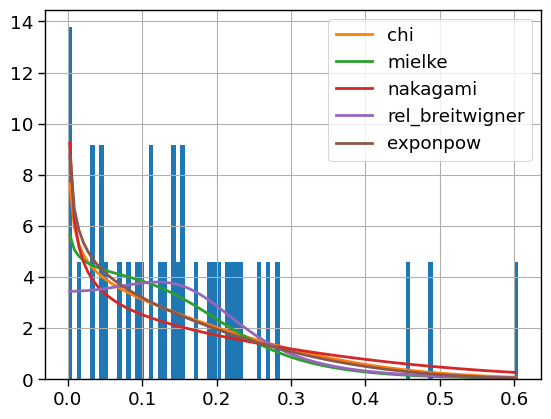

In [23]:
use_fitter(df_tood_major_versions.loc[df_tood_major_versions['system_name']=='CARGO', 'avg_ratio'].to_numpy())

Fitting 111 distributions:  11%|█         | 12/111 [00:43<04:10,  2.54s/it]2024-01-28 21:22:26.445 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted dgamma distribution with error=134.938255)
2024-01-28 21:22:29.097 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED crystalball distribution (taking more than 30 seconds)
Fitting 111 distributions:  14%|█▎        | 15/111 [00:50<04:01,  2.51s/it]2024-01-28 21:22:34.135 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted dweibull distribution with error=135.279653)
2024-01-28 21:22:34.150 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=185.612081)
Fitting 111 distributions:  15%|█▌        | 17/111 [00:54<03:37,  2.31s/it]2024-01-28 21:22:35.484 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted erlang distribution with error=185.856553)
2024-01-28 21:22:36.958 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted foldcauchy di

            sumsquare_error         aic         bic  kl_div  ks_statistic  \
gennorm          134.202199  254.644852  262.519770     inf      0.085654   
dgamma           134.938255  260.861365  268.736283     inf      0.089140   
dweibull         135.279653  242.857261  250.732179     inf      0.095531   
foldcauchy       136.439109  200.471099  208.346017     inf      0.082603   
cauchy           140.804823  253.701292  258.951238     inf      0.099387   

            ks_pvalue  
gennorm      0.419314  
dgamma       0.370477  
dweibull     0.290807  
foldcauchy   0.464943  
cauchy       0.249024  
{'gennorm': {'beta': 0.6856063779551742, 'loc': 0.2086516527869804, 'scale': 0.05666723881552313}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'norminvgauss': {'a': 0.5315835020080085, 'b': 0.2952363141014996, 'loc': 0.16851392623616163, 'scale': 0.10539469191474567}}
{'cosine': {'loc': 4.562388980384707, 'scale': 2.4150102183112948e-30}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scip

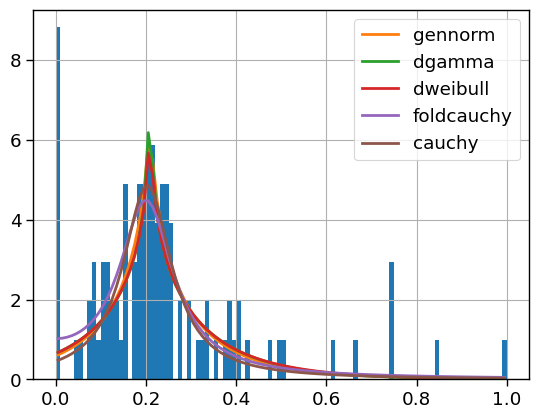

In [24]:
use_fitter(df_tood_major_versions.loc[df_tood_major_versions['system_name']=='NPM', 'avg_ratio'].to_numpy())

Fitting 111 distributions:   1%|          | 1/111 [00:06<11:56,  6.51s/it]2024-01-28 21:35:44.705 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=4192.761782)
2024-01-28 21:35:45.408 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=3929.234013)
Fitting 111 distributions:   7%|▋         | 8/111 [00:22<03:27,  2.02s/it]2024-01-28 21:35:52.201 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1809.58646)
2024-01-28 21:35:54.287 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cosine distribution with error=5035.770517)
Fitting 111 distributions:  11%|█         | 12/111 [00:29<02:50,  1.72s/it]2024-01-28 21:35:57.455 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=3529.797771)
2024-01-28 21:35:59.068 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi distribution with erro

             sumsquare_error         aic         bic  kl_div  ks_statistic  \
halfgennorm      1487.056656  285.140473  291.663634     inf      0.338462   
beta             1583.644623  511.191748  519.889298     inf      0.338462   
gengamma         1629.202260  521.212314  529.909863     inf      0.338462   
gamma            1785.838762  202.119669  208.642830     inf      0.338462   
chi2             1809.586460  179.495665  186.018827     inf      0.338462   

                ks_pvalue  
halfgennorm  3.802614e-07  
beta         3.802614e-07  
gengamma     3.802616e-07  
gamma        3.802615e-07  
chi2         3.802617e-07  
{'halfgennorm': {'beta': 0.3236534020011729, 'loc': -9.604710848083739e-17, 'scale': 0.0006271984828734366}}
{'uniform': {'loc': 0.0, 'scale': 0.5731816334823242}}
{'uniform': {'loc': 0.0, 'scale': 0.5731816334823242}}
{'maxwell': {'loc': -0.13003804976210004, 'scale': 0.13414360953214266}}
{'geninvgauss': {'p': -0.32128410594151524, 'b': 2.193702175146042e-21,

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

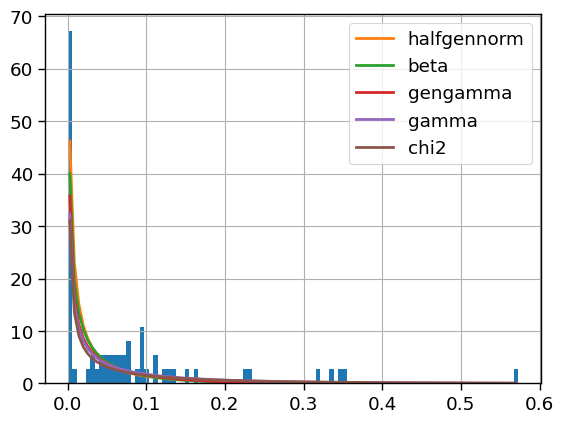

In [25]:
use_fitter(df_tood_major_versions.loc[df_tood_major_versions['system_name']=='PYPI', 'avg_ratio'].to_numpy())

In [ ]:
use_fitter(df_tood_major_versions['avg_ratio'].to_numpy())

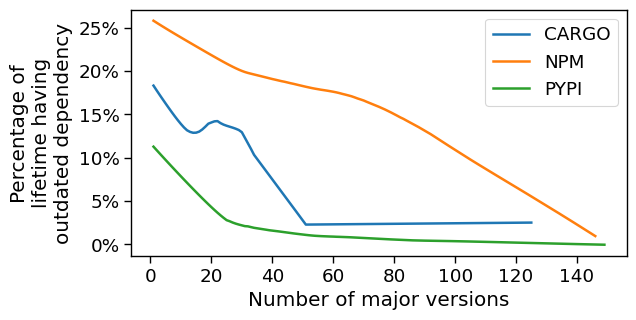

In [65]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_major_versions_small.system_name.unique():
    sns.regplot(df_tood_major_versions_small[df_tood_major_versions_small['system_name'] == system_name],
                x='num_of_major_versions',
                y='avg_ratio',
                lowess=True,
                scatter=False,
                ax=ax,
                label=system_name)
# file to save the figure in pdf format
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_major_version_ratio.pdf")
# plt.ylim(0.0, 1.0)


ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Number of major versions')
ax.set_ylabel('Percentage of\nlifetime having\noutdated dependency')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

In [25]:
print ("time out of date vs number of major versions")
for system_name in df_tood_major_versions_small.system_name.unique():
    print (system_name)
    df_temp = df_tood_major_versions_small[ df_tood_major_versions_small.system_name == system_name ]
    # Calculate the correlation using SciPy
    print ("avg time out of date vs number of major versions")
    corr_coef, p_value = stats.pearsonr(df_temp["avg_out_of_date_duration"], df_temp["num_of_major_versions"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

    print ("percentage of lifetime vs number of major versions")
    corr_coef, p_value = stats.pearsonr(df_temp["avg_ratio"], df_temp["num_of_major_versions"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

    print ("frequency of packages vs number of major versions")
    corr_coef, p_value = stats.pearsonr(df_temp["avg_ratio"], df_temp["num_of_major_versions"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

time out of date vs number of major versions
CARGO
avg time out of date vs number of major versions
Correlation coefficient using SciPy: -0.2917270720703866
P-value using SciPy: 0.08905327171458718
percentage of lifetime vs number of major versions
Correlation coefficient using SciPy: -0.28852324855747175
P-value using SciPy: 0.092783176307187
frequency of packages vs number of major versions
Correlation coefficient using SciPy: -0.28852324855747175
P-value using SciPy: 0.092783176307187
NPM
avg time out of date vs number of major versions
Correlation coefficient using SciPy: -0.0946531446601167
P-value using SciPy: 0.36155700132779744
percentage of lifetime vs number of major versions
Correlation coefficient using SciPy: 0.060855725443505516
P-value using SciPy: 0.5579834580583316
frequency of packages vs number of major versions
Correlation coefficient using SciPy: 0.060855725443505516
P-value using SciPy: 0.5579834580583316
PYPI
avg time out of date vs number of major versions
Corre

TODO: Any heatmap to illustrate the correlations?

# TOOD vs # of versions

In [66]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "time-out-of-date-from-db"), "tofd_vs_versions.csv")
print (data_file)
df_tood_versions = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'num_of_versions', 'avg_out_of_date_duration', 'avg_ratio', 'frequency'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'out_of_date_duration', 'ratio', 'dependents_approx']
rows = df_tood_versions.shape[0]
print (df_tood_versions.shape)
display(df_tood_versions.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/time-out-of-date-from-db/tofd_vs_versions.csv
(4310, 5)


,system_name,num_of_versions,avg_out_of_date_duration,avg_ratio,frequency
0,CARGO,31,217.071944,0.237202,1372
1,CARGO,33,0.000000,0.000000,2
2,CARGO,34,0.000000,0.000000,3
3,CARGO,35,0.000000,0.000000,1
4,CARGO,36,460.000000,0.954357,1


In [23]:
df_tood_versions = df_tood_versions.dropna()
df_tood_versions.groupby(by=['system_name']).describe()

num_of_versions                                                  \
                      count         mean          std   min     25%     50%   
system_name                                                                   
CARGO                1538.0  1341.998049  1627.579989  31.0  434.25   925.5   
NPM                  2113.0  1392.303360  1250.042076   1.0  529.00  1074.0   
PYPI                  650.0   472.533846   465.016536   1.0  163.25   338.0   

                              avg_out_of_date_duration              ...  \
                 75%      max                    count        mean  ...   
system_name                                                         ...   
CARGO        1676.25  23222.0                   1538.0   70.637216  ...   
NPM          1850.00  11460.0                   2113.0  202.621795  ...   
PYPI          604.25   3755.0                    650.0   72.852553  ...   

            avg_ratio           frequency                                     \
                  75%       max     count        mean          std  min  25%   
system_name                                                                    
CARGO        0.177795  1.000000    1538.0    6.590377    50.703444  1.0  1.0   
NPM          0.308283  0.998667    2113.0  687.191197  9221.548938  1.0  1.0   
PYPI         0.153152  0.945860     650.0  221.273846  1576.317555  1.0  1.0   

                                  
             50%   75%       max  
system_name                       
CARGO        2.0   3.0    1372.0  
NPM          3.0  17.0  311335.0  
PYPI         2.0  12.0   27461.0  

[3 rows x 32 columns]

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
pareto           0.000485  3111.280817  3127.295531     inf      0.378685   
expon            0.000485  3109.280888  3119.957364     inf      0.378685   
laplace          0.000689  3251.776396  3262.452872     inf      0.420551   
gumbel_r         0.000766  3437.420613  3448.097089     inf      0.226953   
logistic         0.000851  3618.837641  3629.514117     inf      0.313072   

              ks_pvalue  
pareto    1.051422e-198  
expon     1.051382e-198  
laplace   4.487152e-247  
gumbel_r   4.227861e-70  
logistic  1.904857e-134  
{'pareto': {'b': 121606360.90885863, 'loc': -8589934592.0, 'scale': 8589934591.999999}}
{'vonmises': {'kappa': 0.8003353899091953, 'loc': 0.07228496960342667, 'scale': 1}}
{'vonmises': {'kappa': 0.8003353899091953, 'loc': 0.07228496960342667, 'scale': 1}}
{'gumbel_r': {'loc': 25.606004476582452, 'scale': 59.12286083767902}}
{'uniform': {'loc': 0.0, 'scale': 1592.0}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

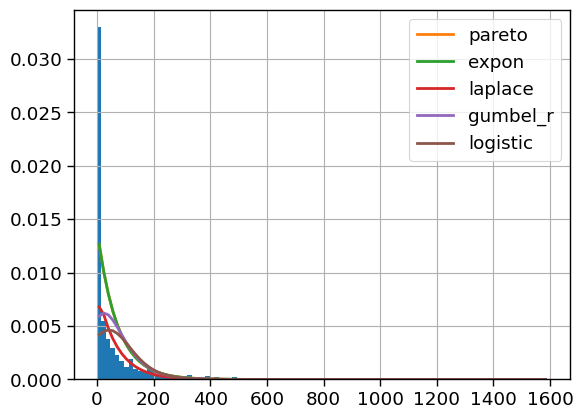

In [28]:
use_fitter(df_tood_versions.loc[df_tood_versions['system_name']=='CARGO', 'avg_out_of_date_duration'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
gumbel_r         0.000020  2237.880147  2249.191875     inf      0.048223   
expon            0.000022  1909.135771  1920.447499     inf      0.103020   
logistic         0.000023  2519.410795  2530.722524     inf      0.114366   
rayleigh         0.000025  2850.743675  2862.055403     inf      0.126827   
laplace          0.000025  2260.018584  2271.330312     inf      0.119825   

             ks_pvalue  
gumbel_r  1.040793e-04  
expon     5.600592e-20  
logistic  1.566507e-24  
rayleigh  4.361441e-30  
laplace   6.798572e-27  
{'gumbel_r': {'loc': 129.55354711656236, 'scale': 116.7993509073394}}
{'vonmises': {'kappa': 0.044383154347669374, 'loc': -0.13207182583242627, 'scale': 1}}
{'vonmises': {'kappa': 0.044383154347669374, 'loc': -0.13207182583242627, 'scale': 1}}
{'gumbel_r': {'loc': 129.55354711656236, 'scale': 116.7993509073394}}
{'uniform': {'loc': 0.0, 'scale': 1707.8333333333333}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

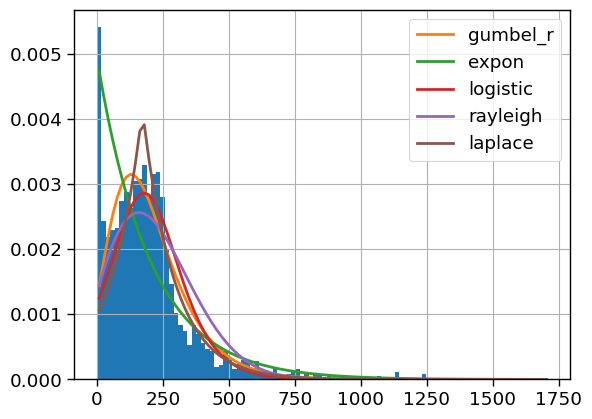

In [29]:
use_fitter(df_tood_versions.loc[df_tood_versions['system_name']=='NPM', 'avg_out_of_date_duration'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
pareto           0.000202  1772.681591  1786.112508     inf      0.316832   
expon            0.000340  2076.342155  2085.296100     inf      0.187006   
gumbel_r         0.000563  2407.466470  2416.420415     inf      0.113584   
logistic         0.000618  2686.213798  2695.167743     inf      0.187146   
rayleigh         0.000627  3185.501662  3194.455607     inf      0.139576   

             ks_pvalue  
pareto    1.642414e-58  
expon     2.251891e-20  
gumbel_r  9.239731e-08  
logistic  2.101887e-20  
rayleigh  1.648513e-11  
{'pareto': {'b': 0.2595189241488969, 'loc': -0.483175884601352, 'scale': 0.48317588460135197}}
{'vonmises': {'kappa': 0.3785706856933546, 'loc': -0.05533668100613198, 'scale': 1}}
{'vonmises': {'kappa': 0.3785706856933546, 'loc': -0.05533668100613198, 'scale': 1}}
{'gumbel_r': {'loc': 39.31157350721395, 'scale': 50.58575509196525}}
{'uniform': {'loc': 0.0, 'scale': 884.906914893617}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

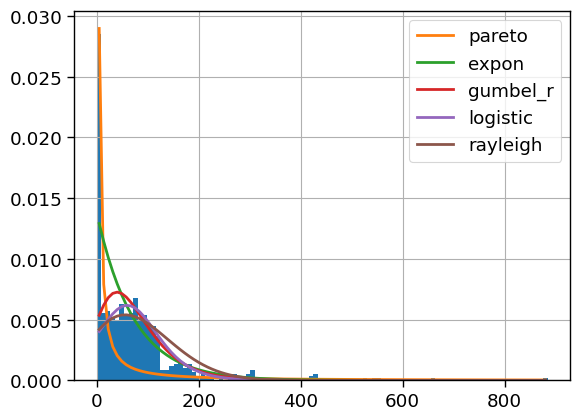

In [30]:
use_fitter(df_tood_versions.loc[df_tood_versions['system_name']=='PYPI', 'avg_out_of_date_duration'].to_numpy())

In [ ]:
use_fitter(df_tood_versions['avg_out_of_date_duration'].to_numpy())

In [67]:
MAX_VERSIONS = 3000
df_tood_versions_small = df_tood_versions[(df_tood_versions['num_of_versions'] >= 0) &
                                            (df_tood_versions['num_of_versions'] <= MAX_VERSIONS)]

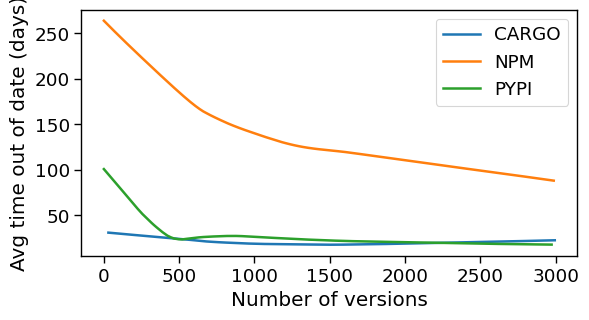

In [68]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_versions_small.system_name.unique():
    sns.regplot(df_tood_versions_small[df_tood_versions_small['system_name'] == system_name],
                x='num_of_versions',
                y='avg_out_of_date_duration',
                lowess=True,
                scatter=False,
                # scatter_kws={'s':2},
                ax=ax,
                label=system_name)
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_versions.pdf")

ax.set_xlabel('Number of versions')
ax.set_ylabel('Avg time out of date (days)')
ax.legend()
# plt.title('Time out of date (all pkgs)\n')
plt.savefig(data_file, bbox_inches='tight')

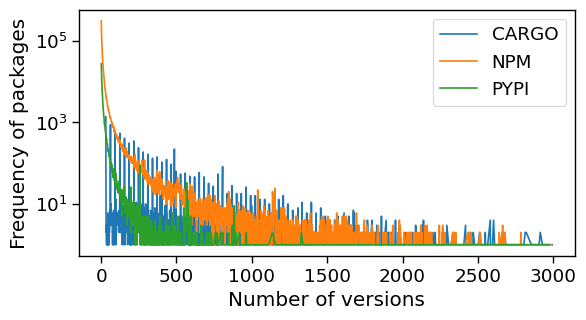

In [69]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_versions_small.system_name.unique():
    sns.lineplot(df_tood_versions_small[df_tood_versions_small['system_name'] == system_name],
                x='num_of_versions',
                y='frequency',
                ax=ax,
                label=system_name)
# file to save the figure in pdf format
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_versions_freq.pdf")
# plt.ylim(0.0, 1.0)

plt.yscale('log')
ax.set_xlabel('Number of versions')
ax.set_ylabel('Frequency of packages')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error         aic         bic  kl_div  ks_statistic  \
expon         1222.408342  416.728162  427.404638     inf      0.364287   
pareto        1222.408364  418.728173  434.742888     inf      0.364286   
laplace       1484.626718  514.495113  525.171590     inf      0.351104   
gumbel_r      1490.591335  498.167759  508.844235     inf      0.201154   
logistic      1551.335957  552.095023  562.771499     inf      0.263450   

              ks_pvalue  
expon     2.011597e-183  
pareto    2.012037e-183  
laplace   5.064957e-170  
gumbel_r   5.000439e-55  
logistic   1.077474e-94  
{'expon': {'loc': 0.0, 'scale': 0.1193508716024209}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'gumbel_r': {'loc': 0.0514185682555405, 'scale': 0.0966026579734787}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


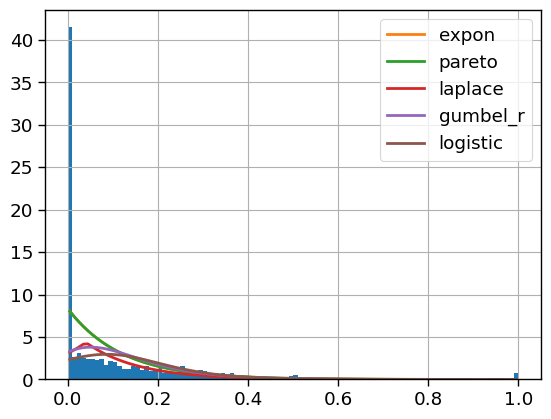

In [31]:
use_fitter(df_tood_versions.loc[df_tood_versions['system_name']=='CARGO', 'avg_ratio'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error         aic         bic  kl_div  ks_statistic  \
laplace         36.657173  267.893409  279.205137     inf      0.062073   
logistic        42.114099  327.320338  338.632066     inf      0.057073   
vonmises        51.931398  399.576503  416.544095     inf      0.104933   
norm            52.436452  402.591066  413.902794     inf      0.107460   
rayleigh        52.630276  278.062561  289.374289     inf      0.077666   

             ks_pvalue  
laplace   1.607304e-07  
logistic  2.006776e-06  
vonmises  1.033543e-20  
norm      1.055733e-21  
rayleigh  1.563090e-11  
{'laplace': {'loc': 0.2372423729700735, 'scale': 0.1137145388415268}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

{'uniform': {'loc': 0.0, 'scale': 0.9986672589960016}}
{'uniform': {'loc': 0.0, 'scale': 0.9986672589960016}}
{'logistic': {'loc': 0.23410564954644025, 'scale': 0.08347036222804245}}
{'uniform': {'loc': 0.0, 'scale': 0.9986672589960016}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


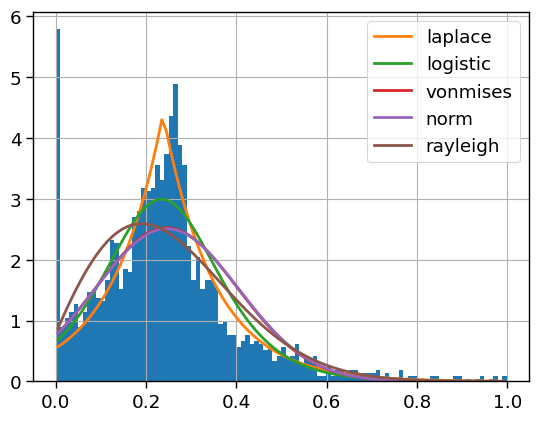

In [32]:
use_fitter(df_tood_versions.loc[df_tood_versions['system_name']=='NPM', 'avg_ratio'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error         aic         bic  kl_div  ks_statistic  \
pareto         343.416816  329.056893  342.487810     inf      0.184615   
expon          345.548481  354.477611  363.431555     inf      0.184756   
gumbel_r       433.737620  530.466843  539.420788     inf      0.098604   
logistic       450.498190  703.635936  712.589881     inf      0.157499   
rayleigh       452.105983  792.324763  801.278707     inf      0.148674   

             ks_pvalue  
pareto    7.289193e-20  
expon     6.804405e-20  
gumbel_r  5.929955e-06  
logistic  1.501816e-14  
rayleigh  5.252944e-13  
{'pareto': {'b': 18.125198138954254, 'loc': -2.1045386496777434, 'scale': 2.104538649677743}}
{'uniform': {'loc': 0.0, 'scale': 0.9458598726114648}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

{'uniform': {'loc': 0.0, 'scale': 0.9458598726114648}}
{'gumbel_r': {'loc': 0.07090782152405344, 'scale': 0.08147618331589879}}
{'kstwo': {'n': 1.0, 'loc': -0.6243152866242039, 'scale': 2.2700636942675154}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


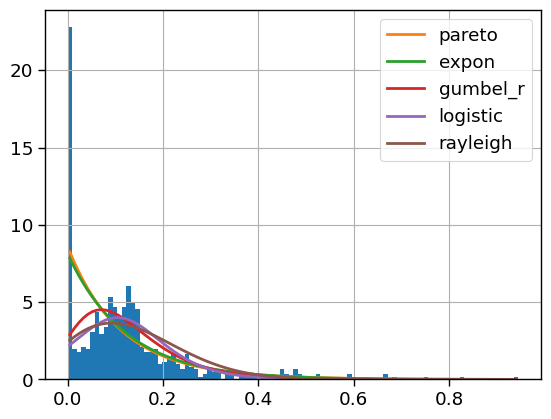

In [33]:
use_fitter(df_tood_versions.loc[df_tood_versions['system_name']=='PYPI', 'avg_ratio'].to_numpy())

In [ ]:
use_fitter(df_tood_versions['avg_ratio'].to_numpy())

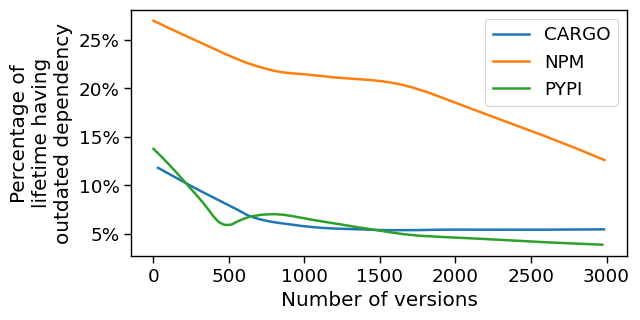

In [70]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_versions_small.system_name.unique():
    sns.regplot(df_tood_versions_small[df_tood_versions_small['system_name'] == system_name],
                x='num_of_versions',
                y='avg_ratio',
                lowess=True,
                scatter=False,
                ax=ax,
                label=system_name)
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_versions_ratio.pdf")
# plt.ylim(0.0, 1.0)


ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Percentage of\nlifetime having\noutdated dependency')
ax.set_xlabel('Number of versions')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

In [57]:
print ("time out of date vs number of versions")
for system_name in df_tood_versions_small.system_name.unique():
    print (system_name)
    df_temp = df_tood_versions_small[ df_tood_versions_small.system_name == system_name ]
    # Calculate the correlation using SciPy
    print ("avg time out of date vs number of versions")
    corr_coef, p_value = stats.pearsonr(df_temp["avg_out_of_date_duration"], df_temp["num_of_versions"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

    print ("percentage of lifetime vs number of versions")
    corr_coef, p_value = stats.pearsonr(df_temp["avg_ratio"], df_temp["num_of_versions"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

    print ("frequency of packages vs number of versions")
    corr_coef, p_value = stats.pearsonr(df_temp["frequency"], df_temp["num_of_versions"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

time out of date vs number of versions
CARGO
avg time out of date vs number of versions
Correlation coefficient using SciPy: 0.10755669021649673
P-value using SciPy: 4.9108295026574546e-05
percentage of lifetime vs number of versions
Correlation coefficient using SciPy: 0.03228314614558595
P-value using SciPy: 0.22423689561226304
frequency of packages vs number of versions
Correlation coefficient using SciPy: -0.1090688039271117
P-value using SciPy: 3.834243117069128e-05
NPM
avg time out of date vs number of versions
Correlation coefficient using SciPy: -0.03358545647886079
P-value using SciPy: 0.14251561045993785
percentage of lifetime vs number of versions
Correlation coefficient using SciPy: 0.009584549844369971
P-value using SciPy: 0.6756585577165729
frequency of packages vs number of versions
Correlation coefficient using SciPy: -0.11381491295376715
P-value using SciPy: 6.213621604960306e-07
PYPI
avg time out of date vs number of versions
Correlation coefficient using SciPy: -0.10

# TOOD vs dependencies

In [28]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "time-out-of-date-from-db"), "tofd_vs_dependencies.csv")
print (data_file)
df_tood_dependencies = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'dependencies_approx', 'avg_out_of_date_duration', 'avg_ratio', 'frequency'],
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'out_of_date_duration', 'ratio', 'dependents_approx']
rows = df_tood_dependencies.shape[0]
print (df_tood_dependencies.shape)
display(df_tood_dependencies.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/time-out-of-date-from-db/tofd_vs_dependencies.csv
(886, 5)


,system_name,dependencies_approx,avg_out_of_date_duration,avg_ratio,frequency
0,CARGO,1,168.734325,0.211837,6587
1,CARGO,2,138.442236,0.164469,1610
2,CARGO,3,124.681883,0.182462,701
3,CARGO,4,130.905128,0.171129,390
4,CARGO,5,136.883895,0.204007,267


In [29]:
df_tood_dependencies = df_tood_dependencies.dropna()
df_tood_dependencies.groupby(by=['system_name']).describe()

dependencies_approx                                              \
                          count        mean         std  min     25%    50%   
system_name                                                                   
CARGO                      28.0   15.785714   11.242634  1.0    7.75   14.5   
NPM                       684.0  413.741228  276.929238  1.0  171.75  375.5   
PYPI                      141.0   79.744681   58.278568  1.0   36.00   71.0   

                            avg_out_of_date_duration              ...  \
                75%     max                    count        mean  ...   
system_name                                                       ...   
CARGO         21.25    54.0                     28.0  118.190953  ...   
NPM          642.25  1119.0                    684.0  240.626321  ...   
PYPI         113.00   303.0                    141.0  191.305403  ...   

            avg_ratio           frequency                                  \
                  75%       max     count         mean           std  min   
system_name                                                                 
CARGO        0.225597  0.336963      28.0   361.785714   1263.234659  1.0   
NPM          0.469678  0.993711     684.0  2113.184211  19962.205475  1.0   
PYPI         0.486502  0.876443     141.0  1011.007092   5669.297068  1.0   

                                          
              25%   50%    75%       max  
system_name                               
CARGO        2.75  11.0  84.75    6587.0  
NPM          1.00   3.0   6.00  385467.0  
PYPI         1.00   5.0  33.00   55303.0  

[3 rows x 32 columns]

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

                    sumsquare_error          aic          bic  kl_div  \
dgamma                     0.003170  1258.941029  1262.937642     inf   
dweibull                   0.003229  1238.231296  1242.227909     inf   
laplace_asymmetric         0.003248  1249.581366  1253.577979     inf   
laplace                    0.003291  1234.255633  1236.920042     inf   
skewcauchy                 0.003292  1295.769093  1299.765707     inf   

                    ks_statistic  ks_pvalue  
dgamma                  0.155388   0.462429  
dweibull                0.128353   0.698155  
laplace_asymmetric      0.096285   0.935396  
laplace                 0.118813   0.781135  
skewcauchy              0.125548   0.723043  

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu


{'dgamma': {'a': 0.8085728916061843, 'loc': 131.87820512820514, 'scale': 60.905246696432556}}
{'vonmises': {'kappa': 0.572333620608987, 'loc': -0.26558071481432677, 'scale': 1}}
{'vonmises': {'kappa': 0.572333620608987, 'loc': -0.26558071481432677, 'scale': 1}}
{'laplace_asymmetric': {'kappa': 1.1262356399861486, 'loc': 131.87820512886378, 'scale': 57.43177210924743}}
{'vonmises': {'kappa': 0.572333620608987, 'loc': -0.26558071481432677, 'scale': 1}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


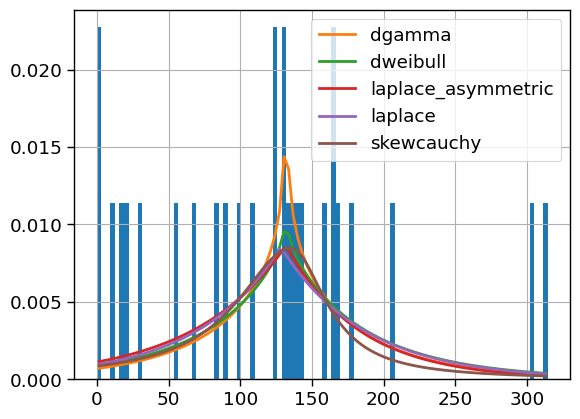

In [36]:
use_fitter(df_tood_dependencies.loc[df_tood_dependencies['system_name']=='CARGO', 'avg_out_of_date_duration'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
pareto           0.000074  1556.533092  1570.116965     inf      0.081290   
expon            0.000074  1554.533090  1563.589006     inf      0.081290   
gumbel_r         0.000120  1600.215802  1609.271718     inf      0.086822   
rayleigh         0.000123  1641.029018  1650.084934     inf      0.119543   
norm             0.000132  1694.053429  1703.109345     inf      0.125968   

             ks_pvalue  
pareto    2.223476e-04  
expon     2.223479e-04  
gumbel_r  6.183610e-05  
rayleigh  5.644106e-09  
norm      6.405086e-10  
{'pareto': {'b': 35698234.331574135, 'loc': -8589934592.0, 'scale': 8589934591.999999}}
{'vonmises': {'kappa': 0.09668835772995653, 'loc': 0.25379948415121234, 'scale': 1}}
{'vonmises': {'kappa': 0.09668835772995653, 'loc': 0.25379948415121234, 'scale': 1}}
{'expon': {'loc': 0.0, 'scale': 240.62632125881535}}
{'vonmises': {'kappa': 0.09668835772995653, 'loc': 0.25379948415121234, 'sca

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

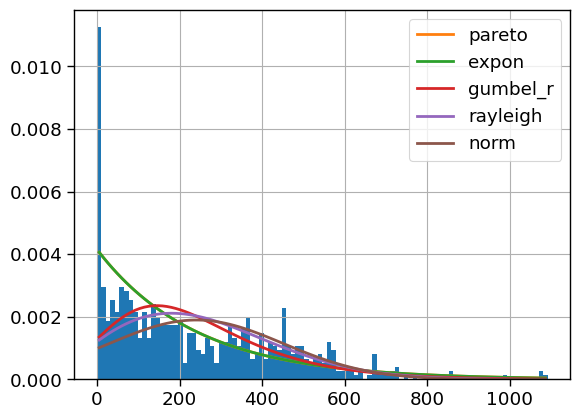

In [37]:
use_fitter(df_tood_dependencies.loc[df_tood_dependencies['system_name']=='NPM', 'avg_out_of_date_duration'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

                 sumsquare_error          aic          bic  kl_div  \
chi                     0.000045  2193.328161  2202.174441     inf   
nakagami                0.000046  2213.777413  2222.623693     inf   
exponpow                0.000050  1762.216927  1771.063206     inf   
beta                    0.000051  1917.730792  1929.525832     inf   
rel_breitwigner         0.000052  2007.993653  2016.839933     inf   

                 ks_statistic  ks_pvalue  
chi                  0.142913   0.005631  
nakagami             0.140422   0.006893  
exponpow             0.179586   0.000189  
beta                 0.155936   0.001845  
rel_breitwigner      0.105508   0.080502  


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

{'chi': {'df': 0.5667083584108759, 'loc': -1.3360543985862112e-27, 'scale': 359.88633782836735}}
{'vonmises': {'kappa': 0.36195871646028505, 'loc': 1.3115514015685923, 'scale': 1}}
{'vonmises': {'kappa': 0.36195871646028505, 'loc': 1.3115514015685923, 'scale': 1}}
{'genlogistic': {'c': 1198.0841268083327, 'loc': -709.3217138621567, 'scale': 116.49820153439859}}
{'vonmises': {'kappa': 0.36195871646028505, 'loc': 1.3115514015685923, 'scale': 1}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


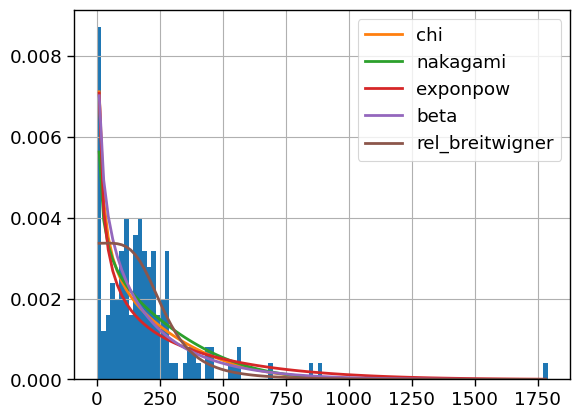

In [38]:
use_fitter(df_tood_dependencies.loc[df_tood_dependencies['system_name']=='PYPI', 'avg_out_of_date_duration'].to_numpy())

In [ ]:
use_fitter(df_tood_dependencies['avg_out_of_date_duration'].to_numpy())

TODO: The # of dependency calculation is not correct. We are now calculating the total # of unique dependencies a package used throughout its total lifetime (including dependencies used in only one version etc).

In [30]:
MAX_DEPENDENCIES = 300
df_tood_dependencies_small = df_tood_dependencies[(df_tood_dependencies['dependencies_approx'] >= 0) &
                                                    (df_tood_dependencies['dependencies_approx'] <= MAX_DEPENDENCIES)]

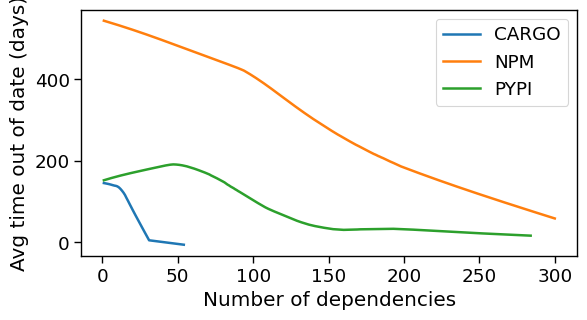

In [72]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_dependencies_small.system_name.unique():
    sns.regplot(df_tood_dependencies_small[df_tood_dependencies_small['system_name'] == system_name],
                x='dependencies_approx',
                y='avg_out_of_date_duration',
                lowess=True,
                scatter=False,
                scatter_kws={'s':2},
                ax=ax,
                label=system_name)
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_dependencies.pdf")

ax.set_ylabel('Avg time out of date (days)')
ax.set_xlabel('Number of dependencies')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

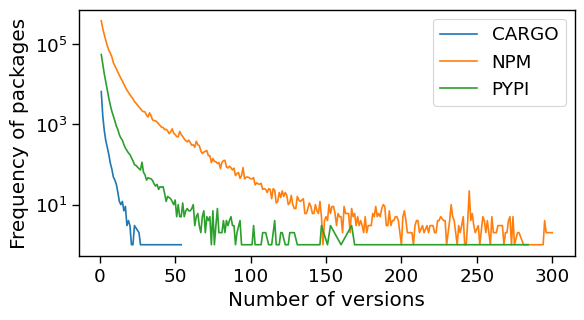

In [73]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_dependencies_small.system_name.unique():
    sns.lineplot(df_tood_dependencies_small[df_tood_dependencies_small['system_name'] == system_name],
                x='dependencies_approx',
                y='frequency',
                ax=ax,
                label=system_name)
# file to save the figure in pdf format
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_dependencies_freq.pdf")
# plt.ylim(0.0, 1.0)

plt.yscale('log')
ax.set_xlabel('Number of versions')
ax.set_ylabel('Frequency of packages')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

                    sumsquare_error         aic         bic  kl_div  \
rel_breitwigner         2973.312332 -161.162853 -157.166240     inf   
cauchy                  2977.787506  -86.764845  -84.100436     inf   
skewcauchy              2977.958682  -84.956178  -80.959564     inf   
genhyperbolic           2988.310923 -128.737088 -122.076066     inf   
laplace_asymmetric      2994.295093 -134.021247 -130.024633     inf   

                    ks_statistic  ks_pvalue  
rel_breitwigner         0.118752   0.781643  
cauchy                  0.148373   0.520729  
skewcauchy              0.148188   0.522307  
genhyperbolic           0.116979   0.796345  
laplace_asymmetric      0.116964   0.796467  
{'rel_breitwigner': {'rho': 1.9109408535224253, 'loc': -4.569801213220872e-08, 'scale': 0.10520216798750946}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

{'uniform': {'loc': 0.0, 'scale': 0.336962808781181}}
{'uniform': {'loc': 0.0, 'scale': 0.336962808781181}}
{'laplace_asymmetric': {'kappa': 1.4089355521651004, 'loc': 0.21035681296223574, 'scale': 0.05586864424323601}}
{'rdist': {'c': 1.3053444580350853, 'loc': 1.166347371699246, 'scale': 6.95399974033267e-30}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


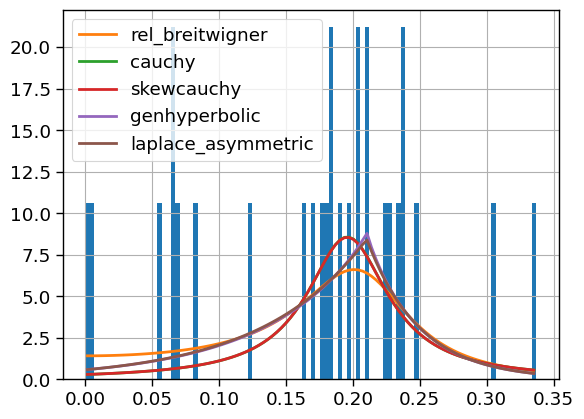

In [39]:
use_fitter(df_tood_dependencies.loc[df_tood_dependencies['system_name']=='CARGO', 'avg_ratio'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

           sumsquare_error         aic         bic  kl_div  ks_statistic  \
hypsecant        18.634096  343.231708  352.287624     inf      0.048729   
logistic         21.977364  385.470697  394.526612     inf      0.048297   
laplace          27.135198  295.694954  304.750870     inf      0.055657   
cauchy           33.061788  216.625002  225.680918     inf      0.086040   
vonmises         43.061276  499.045433  512.629307     inf      0.106281   

              ks_pvalue  
hypsecant  7.513823e-02  
logistic   7.959434e-02  
laplace    2.778710e-02  
cauchy     7.448972e-05  
vonmises   3.503259e-07  
{'hypsecant': {'loc': 0.415277018964204, 'scale': 0.06501640873031073}}
{'uniform': {'loc': 0.0, 'scale': 0.9937106918238992}}
{'uniform': {'loc': 0.0, 'scale': 0.9937106918238992}}
{'logistic': {'loc': 0.41302079702519073, 'scale': 0.05531269996488316}}
{'uniform': {'loc': 0.0, 'scale': 0.9937106918238992}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

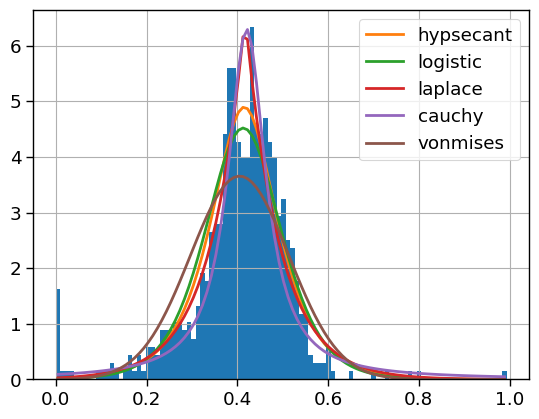

In [40]:
use_fitter(df_tood_dependencies.loc[df_tood_dependencies['system_name']=='NPM', 'avg_ratio'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

            sumsquare_error        aic        bic  kl_div  ks_statistic  \
dgamma           146.299715  73.560837  82.407117     inf      0.068562   
dweibull         152.920028  64.128381  72.974660     inf      0.056028   
gausshyper       153.221847  19.987830  37.680389     inf      0.072240   
loglaplace       158.712046  57.639339  66.485618     inf      0.058139   
laplace          158.952577  58.003565  63.901085     inf      0.057476   

            ks_pvalue  
dgamma       0.499695  
dweibull     0.746306  
gausshyper   0.433257  
loglaplace   0.704870  
laplace      0.717984  


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

{'dgamma': {'a': 0.8277982224073386, 'loc': 0.36535020605201596, 'scale': 0.18047804912199994}}
{'uniform': {'loc': 0.0, 'scale': 0.8764427539448726}}
{'uniform': {'loc': 0.0, 'scale': 0.8764427539448726}}
{'genlogistic': {'c': 1.5875958905572647, 'loc': 0.2788304598995005, 'scale': 0.13494092682098002}}
{'powerlaw': {'a': 0.06176211596008445, 'loc': -2.2250738585072014e-308, 'scale': 0.8764427539448727}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


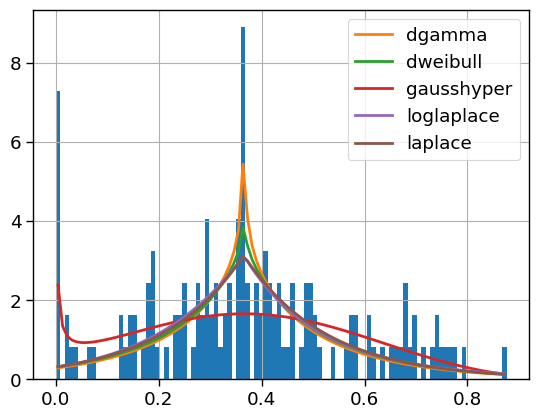

In [41]:
use_fitter(df_tood_dependencies.loc[df_tood_dependencies['system_name']=='PYPI', 'avg_ratio'].to_numpy())

In [ ]:
use_fitter(df_tood_dependencies['avg_ratio'].to_numpy())

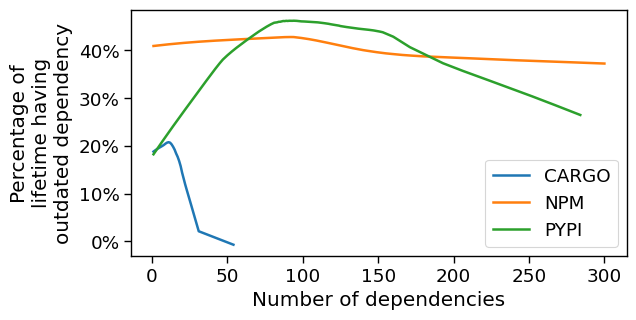

In [75]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_dependencies_small.system_name.unique():
    sns.regplot(df_tood_dependencies_small[df_tood_dependencies_small['system_name'] == system_name],
                x='dependencies_approx',
                y='avg_ratio',
                lowess=True,
                scatter=False,
                ax=ax,
                label=system_name)
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_dependencies_ratio.pdf")
# plt.ylim(0.0, 1.0)

ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Percentage of\nlifetime having\noutdated dependency')
ax.set_xlabel('Number of dependencies')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

In [66]:
print ("time out of date vs number of dependencies")
for system_name in df_tood_dependencies_small.system_name.unique():
    print (system_name)
    df_temp = df_tood_dependencies_small[ df_tood_dependencies_small.system_name == system_name ]
    # Calculate the correlation using SciPy
    print ("avg time out of date vs number of dependencies")
    corr_coef, p_value = stats.pearsonr(df_temp["avg_out_of_date_duration"], df_temp["dependencies_approx"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

    print ("percentage of lifetime vs number of dependencies")
    corr_coef, p_value = stats.pearsonr(df_temp["avg_ratio"], df_temp["dependencies_approx"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

    print ("frequency of packages vs number of dependencies")
    corr_coef, p_value = stats.pearsonr(df_temp["frequency"], df_temp["dependencies_approx"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

time out of date vs number of dependencies
CARGO
avg time out of date vs number of dependencies
Correlation coefficient using SciPy: -0.4765865451288838
P-value using SciPy: 0.01034726233220435
percentage of lifetime vs number of dependencies
Correlation coefficient using SciPy: -0.5898877070603467
P-value using SciPy: 0.0009538647084014637
frequency of packages vs number of dependencies
Correlation coefficient using SciPy: -0.3650801534197446
P-value using SciPy: 0.05609756482932866
NPM
avg time out of date vs number of dependencies
Correlation coefficient using SciPy: -0.750119136298289
P-value using SciPy: 2.1546242580561266e-52
percentage of lifetime vs number of dependencies
Correlation coefficient using SciPy: -0.25727235342876686
P-value using SciPy: 1.1714583372964385e-05
frequency of packages vs number of dependencies
Correlation coefficient using SciPy: -0.2717143398967267
P-value using SciPy: 3.5134245374812965e-06
PYPI
avg time out of date vs number of dependencies
Correlat

# TOOD vs dependents

In [34]:
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "data"), "time-out-of-date-from-db"), "tofd_vs_dependents.csv")
print (data_file)
df_tood_dependents = pd.read_csv(data_file,
                header=0,
                sep=';',
                on_bad_lines='skip',
                usecols=['system_name', 'dependents_approx', 'avg_out_of_date_duration', 'avg_ratio', 'frequency'],
                dtype={'dependents_approx':'Int64'}
                )
# df.columns = ['system_name', 'package_name', 'total_requirement_duration', 'out_of_date_duration', 'ratio', 'dependents_approx']
rows = df_tood_dependents.shape[0]
print (df_tood_dependents.shape)
display(df_tood_dependents.head())

/Users/imranur/Research/security-metrics/code/visualize-data/../../data/time-out-of-date-from-db/tofd_vs_dependents.csv
(8756, 5)


,system_name,dependents_approx,avg_out_of_date_duration,avg_ratio,frequency
0,CARGO,0,168.533953,0.223622,5432
1,CARGO,1,177.296522,0.216054,729
2,CARGO,2,168.704370,0.216440,511
3,CARGO,3,182.440066,0.197411,298
4,CARGO,4,190.690095,0.196075,248


In [35]:
df_tood_dependents = df_tood_dependents.dropna()
df_tood_dependents.groupby(by=['system_name']).describe()

dependents_approx                                           \
                        count          mean           std  min     25%   
system_name                                                              
CARGO                   644.0   3091.150621   8535.216056  0.0  165.75   
NPM                    7327.0  21862.661253  54006.833035  0.0  1879.5   
PYPI                    754.0    2760.35809    6896.91657  0.0  191.25   

                                       avg_out_of_date_duration              \
                50%      75%       max                    count        mean   
system_name                                                                   
CARGO         474.0  1585.25  103586.0                    644.0   93.431864   
NPM          5249.0  18001.5  973859.0                   7327.0  231.898409   
PYPI          491.5   1663.5   76897.0                    754.0   42.735922   

             ... avg_ratio      frequency                                      \
             ...       75%  max     count        mean           std  min  25%   
system_name  ...                                                                
CARGO        ...  0.158423  1.0     644.0   15.725155    217.592927  1.0  1.0   
NPM          ...  0.268274  1.0    7327.0  197.273645  12918.538549  1.0  1.0   
PYPI         ...  0.073210  1.0     754.0  189.057029   4293.223464  1.0  1.0   

                                  
             50%  75%        max  
system_name                       
CARGO        1.0  2.0     5432.0  
NPM          1.0  2.0  1099470.0  
PYPI         1.0  3.0   117484.0  

[3 rows x 32 columns]

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon            0.000393  2864.741573  2873.676970     inf      0.416329   
pareto           0.000393  2866.741550  2880.144646     inf      0.416329   
laplace          0.000531  2992.258833  3001.194230     inf      0.432174   
gumbel_r         0.000581  3134.224772  3143.160170     inf      0.233225   
logistic         0.000634  3299.595248  3308.530645     inf      0.311703   

              ks_pvalue  
expon     1.338236e-101  
pareto    1.338278e-101  
laplace   7.905274e-110  
gumbel_r   2.741122e-31  
logistic   4.379204e-56  
{'expon': {'loc': 0.0, 'scale': 93.43186361808947}}
{'vonmises': {'kappa': 0.9105811346416022, 'loc': 0.07008188471780041, 'scale': 1}}
{'vonmises': {'kappa': 0.9105811346416022, 'loc': 0.07008188471780041, 'scale': 1}}
{'gumbel_r': {'loc': 33.88903780360955, 'scale': 78.27309529122171}}
{'uniform': {'loc': 0.0, 'scale': 1825.0}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

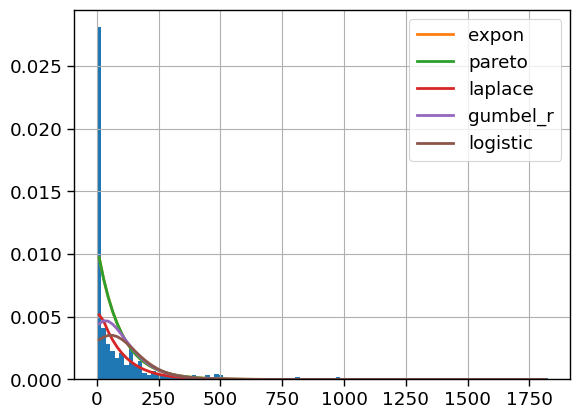

In [44]:
use_fitter(df_tood_dependents.loc[df_tood_dependents['system_name']=='CARGO', 'avg_out_of_date_duration'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
pareto           0.000013  2124.412436  2145.110401     inf      0.269962   
expon            0.000016  2989.348781  3003.147424     inf      0.190956   
gumbel_r         0.000035  3497.736333  3511.534976     inf      0.146298   
laplace          0.000038  3286.592560  3300.391203     inf      0.271491   
logistic         0.000041  3820.961189  3834.759832     inf      0.237238   

              ks_pvalue  
pareto     0.000000e+00  
expon     1.864935e-234  
gumbel_r  2.480297e-137  
laplace    0.000000e+00  
logistic   0.000000e+00  
{'pareto': {'b': 0.2686442053269715, 'loc': -1.4675356236642094, 'scale': 1.4675356236642092}}
{'vonmises': {'kappa': 0.38061524004138997, 'loc': 0.030279452159472697, 'scale': 1}}
{'vonmises': {'kappa': 0.38061524004138997, 'loc': 0.030279452159472697, 'scale': 1}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

{'gumbel_r': {'loc': 111.27107264839367, 'scale': 170.2894508179355}}
{'gumbel_l': {'loc': 452.1046845703373, 'scale': 725.8511069132757}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


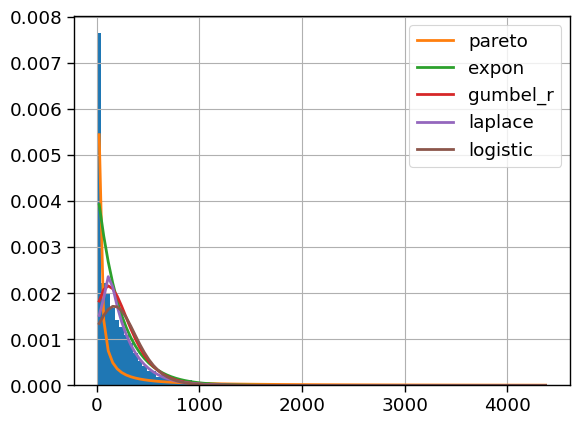

In [45]:
use_fitter(df_tood_dependents.loc[df_tood_dependents['system_name']=='NPM', 'avg_out_of_date_duration'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon            0.002582  2363.022876  2372.273661     inf      0.405308   
pareto           0.002582  2365.022866  2378.899043     inf      0.405308   
laplace          0.003530  2475.867149  2485.117934     inf      0.373381   
gumbel_r         0.003574  2605.211770  2614.462554     inf      0.225793   
logistic         0.003824  2786.325908  2795.576692     inf      0.280126   

              ks_pvalue  
expon     2.038764e-112  
pareto    2.038885e-112  
laplace    7.102494e-95  
gumbel_r   2.927291e-34  
logistic   8.057449e-53  
{'expon': {'loc': 0.0, 'scale': 42.735922162223204}}
{'vonmises': {'kappa': 1.0091569988798565, 'loc': -0.023340211892088902, 'scale': 1}}
{'vonmises': {'kappa': 1.0091569988798565, 'loc': -0.023340211892088902, 'scale': 1}}
{'gumbel_r': {'loc': 17.390971108355778, 'scale': 34.80298992778208}}
{'uniform': {'loc': 0.0, 'scale': 687.2}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

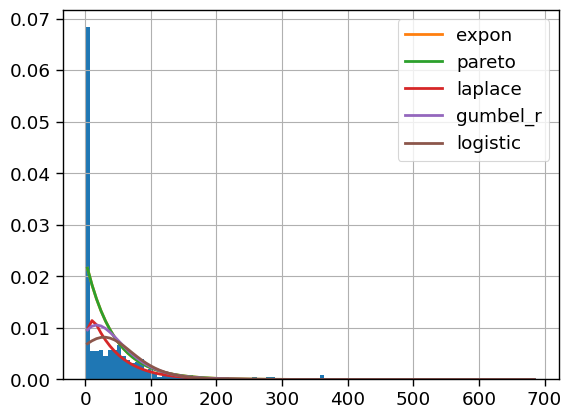

In [46]:
use_fitter(df_tood_dependents.loc[df_tood_dependents['system_name']=='PYPI', 'avg_out_of_date_duration'].to_numpy())

In [ ]:
use_fitter(df_tood_dependents['avg_out_of_date_duration'].to_numpy())

In [36]:
MAX_DEPENDENTS = 70000
df_tood_dependents_small = df_tood_dependents[(df_tood_dependents['dependents_approx'] >= 0) &
                                                (df_tood_dependents['dependents_approx'] <= MAX_DEPENDENTS)]

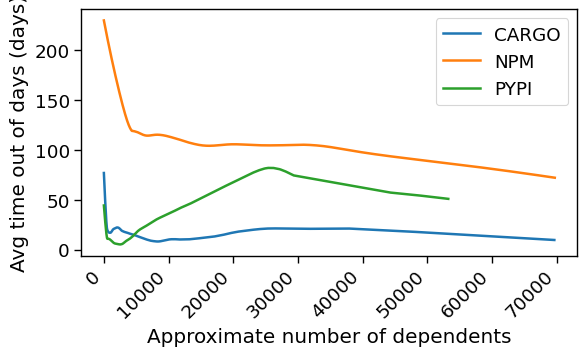

In [76]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_dependents_small.system_name.unique():
    sns.regplot(df_tood_dependents_small[df_tood_dependents_small['system_name'] == system_name],
                x='dependents_approx',
                y='avg_out_of_date_duration',
                lowess=True,
                scatter=False,
                # scatter_kws={'s':2},
                ax=ax,
                label=system_name)
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_dependents.pdf")

ax.set_ylabel('Avg time out of days (days)')
ax.set_xlabel('Approximate number of dependents')
plt.xticks(rotation=45, ha='right')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

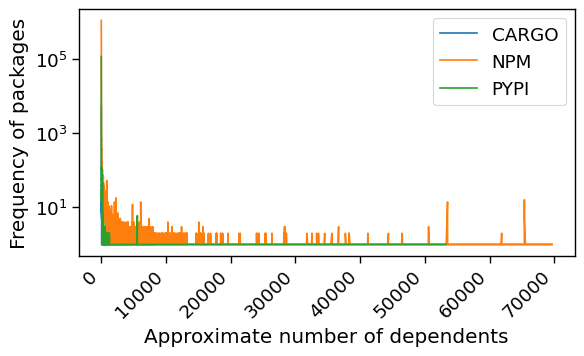

In [78]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_dependents_small.system_name.unique():
    sns.lineplot(df_tood_dependents_small[df_tood_dependents_small['system_name'] == system_name],
                x='dependents_approx',
                y='frequency',
                ax=ax,
                label=system_name)
# file to save the figure in pdf format
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_dependents_freq.pdf")
# plt.ylim(0.0, 1.0)

plt.yscale('log')
ax.set_xlabel('Approximate number of dependents')
ax.set_ylabel('Frequency of packages')
plt.xticks(rotation=45, ha='right')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error         aic         bic  kl_div  ks_statistic  \
expon         1475.238030  478.506607  487.442005     inf      0.409938   
pareto        1475.238060  480.506618  493.909715     inf      0.409938   
laplace       1759.431729  582.130102  591.065500     inf      0.389255   
gumbel_r      1795.404249  562.424972  571.360369     inf      0.224547   
logistic      1868.636858  615.010622  623.946019     inf      0.284218   

             ks_pvalue  
expon     2.198591e-98  
pareto    2.198763e-98  
laplace   2.222542e-88  
gumbel_r  5.199726e-29  
logistic  1.580664e-46  
{'expon': {'loc': 0.0, 'scale': 0.1089458074834527}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'gumbel_r': {'loc': 0.04361706575385699, 'scale': 0.09038244262429948}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


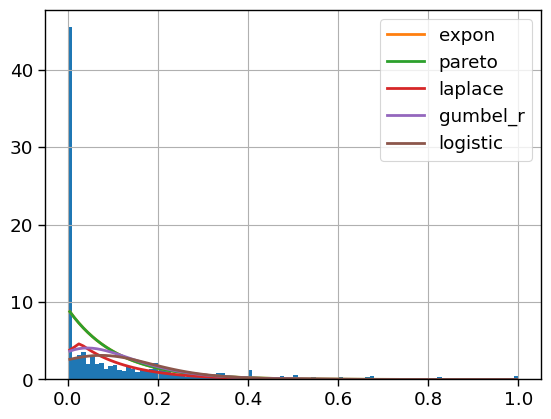

In [47]:
use_fitter(df_tood_dependents.loc[df_tood_dependents['system_name']=='CARGO', 'avg_ratio'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error         aic         bic    kl_div  ks_statistic  \
pareto         309.053409  199.026651  219.724615  0.185327      0.182892   
expon          317.260217  200.298451  214.097094  0.178265      0.183629   
gumbel_r       407.069169  257.297326  271.095969  0.211335      0.109237   
rayleigh       416.851129  282.469135  296.267778  0.235021      0.124199   
logistic       424.493306  311.785810  325.584453  0.237190      0.174358   

              ks_pvalue  
pareto    5.832987e-215  
expon     1.043878e-216  
gumbel_r   1.340077e-76  
rayleigh   5.750382e-99  
logistic  2.840449e-195  
{'pareto': {'b': 10.392644510333957, 'loc': -1.7775205758328911, 'scale': 1.777520575832891}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'gumbel_r': {'loc': 0.10465926969304824, 'scale': 0.13166232918230253}}
{'gumbel_l': {'loc': 0.3005251920025392, 'scale': 0.26471685168544234}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

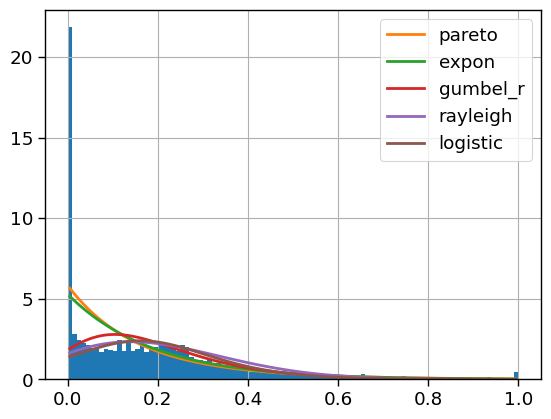

In [48]:
use_fitter(df_tood_dependents.loc[df_tood_dependents['system_name']=='NPM', 'avg_ratio'].to_numpy())

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

          sumsquare_error          aic          bic  kl_div  ks_statistic  \
pareto        1210.783348  1232.528889  1246.405067     inf      0.403461   
expon         1210.783364  1230.528959  1239.779744     inf      0.403461   
laplace       1672.850609  1354.905383  1364.156168     inf      0.392065   
gumbel_r      1740.342745  1506.759330  1516.010115     inf      0.222915   
logistic      1880.662300  1705.681927  1714.932711     inf      0.283560   

              ks_pvalue  
pareto    2.345372e-111  
expon     2.345340e-111  
laplace   6.151524e-105  
gumbel_r   2.150774e-33  
logistic   3.889757e-54  
{'pareto': {'b': 75714646.675939, 'loc': -4194304.0, 'scale': 4194303.9999999995}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_outpu

{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}
{'gumbel_r': {'loc': 0.022287304830346532, 'scale': 0.04535357529951147}}
{'uniform': {'loc': 0.0, 'scale': 1.0}}


/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


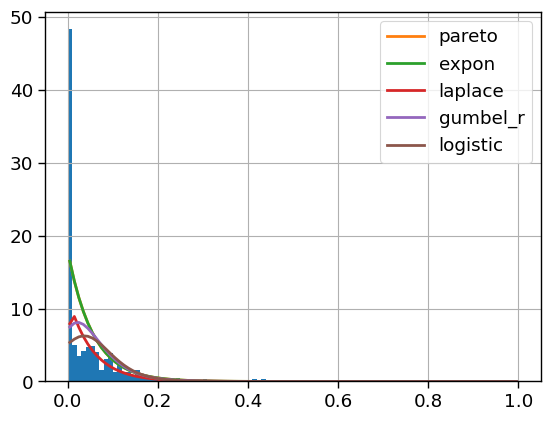

/Users/imranur/Research/security-metrics/secmet_venv/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [49]:
use_fitter(df_tood_dependents.loc[df_tood_dependents['system_name']=='PYPI', 'avg_ratio'].to_numpy())

In [ ]:
use_fitter(df_tood_dependents['avg_ratio'].to_numpy())

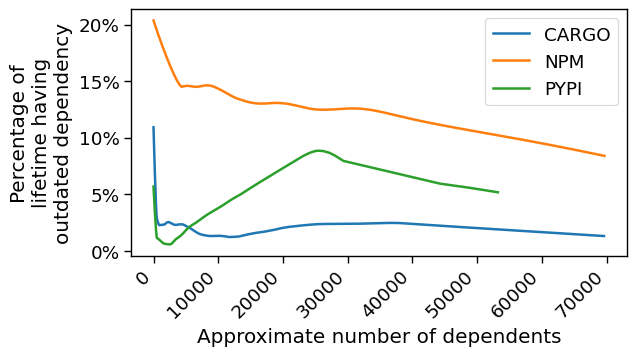

In [80]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6.4, 3.2))

for system_name in df_tood_dependents_small.system_name.unique():
    sns.regplot(df_tood_dependents_small[df_tood_dependents_small['system_name'] == system_name],
                x='dependents_approx',
                y='avg_ratio',
                lowess=True,
                scatter=False,
                ax=ax,
                label=system_name)
data_file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir), "results"), "time-out-of-date-from-db"), "tood_vs_dependents_ratio.pdf")
# plt.ylim(0.0, 1.0)


ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('Percentage of\nlifetime having\noutdated dependency')
ax.set_xlabel('Approximate number of dependents')
plt.xticks(rotation=45, ha='right')
ax.legend()
# plt.title('Time out of date\n')
plt.savefig(data_file, bbox_inches='tight')

In [64]:
print ("time out of date vs number of dependents")
for system_name in df_tood_dependents_small.system_name.unique():
    print (system_name)
    df_temp = df_tood_dependents_small[ df_tood_dependents_small.system_name == system_name ]
    # Calculate the correlation using SciPy
    print ("avg time out of date vs number of dependents")
    corr_coef, p_value = stats.pearsonr(df_temp["avg_out_of_date_duration"], df_temp["dependents_approx"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

    print ("percentage of lifetime vs number of dependents")
    corr_coef, p_value = stats.pearsonr(df_temp["avg_ratio"], df_temp["dependents_approx"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

    print ("frequency of packages vs number of dependents")
    corr_coef, p_value = stats.pearsonr(df_temp["frequency"], df_temp["dependents_approx"])
    print("Correlation coefficient using SciPy:", corr_coef)
    print("P-value using SciPy:", p_value)

time out of date vs number of dependents
CARGO
avg time out of date vs number of dependents
Correlation coefficient using SciPy: -0.0880945010875036
P-value using SciPy: 0.025608034473506857
percentage of lifetime vs number of dependents
Correlation coefficient using SciPy: -0.08175471789830442
P-value using SciPy: 0.03836731805492231
frequency of packages vs number of dependents
Correlation coefficient using SciPy: -0.027124552819827712
P-value using SciPy: 0.4926745304278338
NPM
avg time out of date vs number of dependents
Correlation coefficient using SciPy: -0.03744412578630338
P-value using SciPy: 0.0019874835813767262
percentage of lifetime vs number of dependents
Correlation coefficient using SciPy: -0.09050652131972861
P-value using SciPy: 7.063731754777033e-14
frequency of packages vs number of dependents
Correlation coefficient using SciPy: -0.011455246029767174
P-value using SciPy: 0.3443213101078013
PYPI
avg time out of date vs number of dependents
Correlation coefficient u